## AIRBNB NEW USER BOOKING PREDICTION PROBLEM :

### Business Problem :

Airbnb has become a very popular choice among the travellers around the world for the kind of unique experiences that they provide and also for presenting an alternative to costly hotels. It is currently present in more than 34000+cities across 190 countries. Customers can make their bookings either through the website application or using the iOS/Android application. Airbnb is consistently trying to improve this booking experience to make it easier for the first time customer.

### Problem Statement :

The problem that this case study is dealing with predicts the location that a user is most likely to book for the first time.

The accurate prediction helps to decrease the average time required to book by sharing more personalized recommendations and also in better forecasting of the demand. We use the browser’s session data as well as the user’s demographic information that is provided to us to create features that help in solving the problem.

### Mapping the real world problem as a ML problem:

This is a multi-class classification problem where given the user data we have to predict top five most probable destinations among any of the 12 choices -US’, ‘FR’, ‘CA’, ‘GB’, ‘ES’,‘IT’, ‘PT’, ‘NL’,’DE’, ‘AU’, ‘NDF’ and ‘others’. ‘NDF’ and ‘others’ are different from each other. ‘NDF’ means there has been no booking done for this user and ‘others’ means that there has been a booking but to a country not present in the list given.

### Data set Analysis: 

1) Files given: train_users, test_users, sessions, countries, and age_gender_bkts.

2) Total File Size : 64.71MB

3) Total number of records: 2,13,451 (train_users), 62,096 (test_users)

4) The first two files contain the individual information of the users i.e. age, gender, signup_method, language, country_destination (target), etc.

5) The sessions.csv contains web session data of the users. Each record in this dataset is identified with user_id field that is corresponding to the id field of the train datasets. We find several session records containing information from the different times the particular user has accessed the Airbnb application.

6) The sessions.csv has data of users from 2014 onwards whereas the train dataset has records dating back to 2010.

7) The last two datasets contain more general statistical information of the destination and the users’ respectively.

### Real World Business Constraints:

a) Low latency is important.

b) Mis-classification cost is not considerably high as the user can very easily change the destinations if he/she doesn’t like the given recommendations.

c) Interpretability of the result is not much needed.

### Performance Metric:

NDCG (Normalized discounted cumulative gain) as required by the Kaggle competition.

### Importing Libraries :

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
from wordcloud import WordCloud
from tqdm import tqdm
from datetime import datetime, date

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
import pickle
import joblib

### EXPLORATORY DATA ANALYSIS :

#### Reading the Train User File :

In [467]:
train_df = pd.read_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\train_users_2.csv\train_users_2.csv')
print('Shape of the Train Data : ',train_df.shape)
print('Columns of Train Data : ', train_df.columns)
train_df.head()

Shape of the Train Data :  (213451, 16)
Columns of Train Data :  Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [199]:
train_df.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


Only <b>age</b> and <b>signup_flow</b> are numerical fields. Rest all are either date fields or categorical. So describe function didnt give any statistics for those.<b>Timestamp_first_active</b> is given without any separator so that is also considered as a numerical field, which is wrong. We will rectify this later.

In [116]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [117]:
train_df.isnull().any()

id                         False
date_account_created       False
timestamp_first_active     False
date_first_booking          True
gender                     False
age                         True
signup_method              False
signup_flow                False
language                   False
affiliate_channel          False
affiliate_provider         False
first_affiliate_tracked     True
signup_app                 False
first_device_type          False
first_browser              False
country_destination        False
dtype: bool

<b>date_first_booking</b>, <b>age</b> and <b>first_affiliate_tracked</b> are the only <b>three</b> fields that have null values.

In [118]:
print('Total Null Values in Age field : ',train_df['age'].isnull().sum())
print('Total Null Values in date_first_booking field : ',train_df['date_first_booking'].isnull().sum())
print('Total Null Values in first_affiliate_tracked field : ',train_df['first_affiliate_tracked'].isnull().sum())

Total Null Values in Age field :  87990
Total Null Values in date_first_booking field :  124543
Total Null Values in first_affiliate_tracked field :  6065


In [119]:
print('Total number of records in Train : ' , train_df.shape[0])

Total number of records in Train :  213451


### UNIVARIATE ANALYSIS :

###### 1. Analysing the Gender Field :

In [87]:
print('Total unique values in gender field :')
gender = train_df['gender'].value_counts()
print(gender)

Total unique values in gender field :
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64


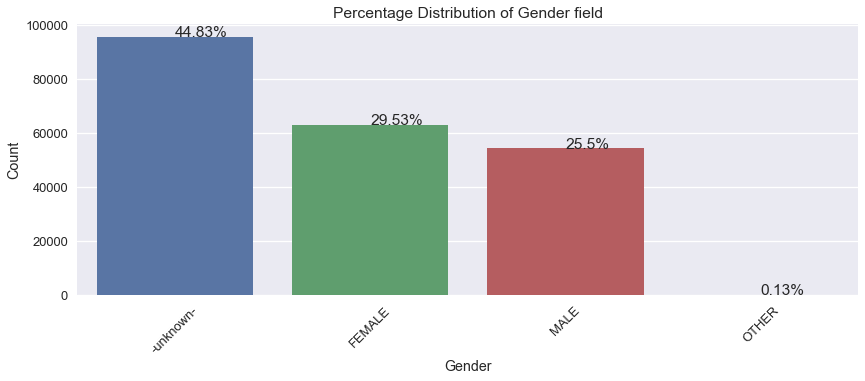

In [121]:
#https://matplotlib.org/3.1.0/tutorials/text/text_intro.html
#https://matplotlib.org/3.1.1/gallery/ticks_and_spines/ticklabels_rotation.html
#https://seaborn.pydata.org/generated/seaborn.set_context.html

#Got the idea of giving percentage values in the plot itself from the given kaggle kernel : 
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

#Plotting Gender Field :

plt.figure(figsize=(14,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('gender', data = train_df,order = train_df['gender'].value_counts().index)
for i in range(gender.shape[0]):
    range_count = gender[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Gender field')
plt.show()

We see there are <b>4</b> categories in the <b>Gender</b> field. Majority of the users <b>(44.83%)</b> have not disclosed their gender. Among those who have, female users are marginally more than the male users with 29.53% as female and 25.5% as male. A small percentage (0.13%) of users have selected <b>'other'</b> as their gender. This means that they might belong to the non-binary category.

##### 2.  Analysing the 'signup_method' field :

In [122]:
print('Total unique values in signup_method field :')
signup_method = train_df['signup_method'].value_counts()
print(signup_method)

Total unique values in signup_method field :
basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64


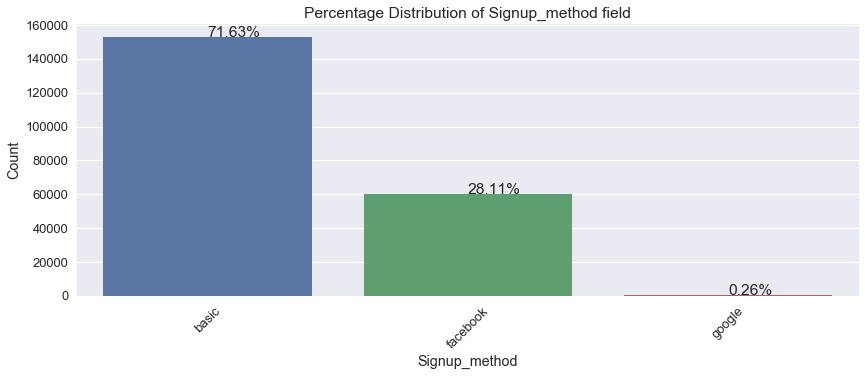

In [123]:
#https://matplotlib.org/3.1.0/tutorials/text/text_intro.html

#Plotting signup_method field :

plt.figure(figsize=(14,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('signup_method', data = train_df,order = train_df['signup_method'].value_counts().index)
for i in range(signup_method.shape[0]):
    range_count = signup_method[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Signup_method')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Signup_method field')
plt.show()

Majority of the users <b>(71.63%)</b> have used the <b>basic</b> method to create an account on the Airbnb application. This means that they have used the normal email-password as a method to signup. Among the remaining users, a huge majority <b>(28.11%)</b> have used <b>facebook</b> to signup. A very few percentage <b>(0.26%)</b> of people used google to signup.

###### This concludes that google is not much preferrred as a signup method. Also, it can mean that users are less inclined to share their personal information in the form of facebook or google linkup with their Airbnb account and hence they have chosen the basic email-password method to access their account.

##### 3. Analysing the Language Field :

In [124]:
print('Total unique values in language field :')
language = train_df['language'].value_counts()
print(language)

Total unique values in language field :
en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
is         5
ca         5
hr         2
Name: language, dtype: int64


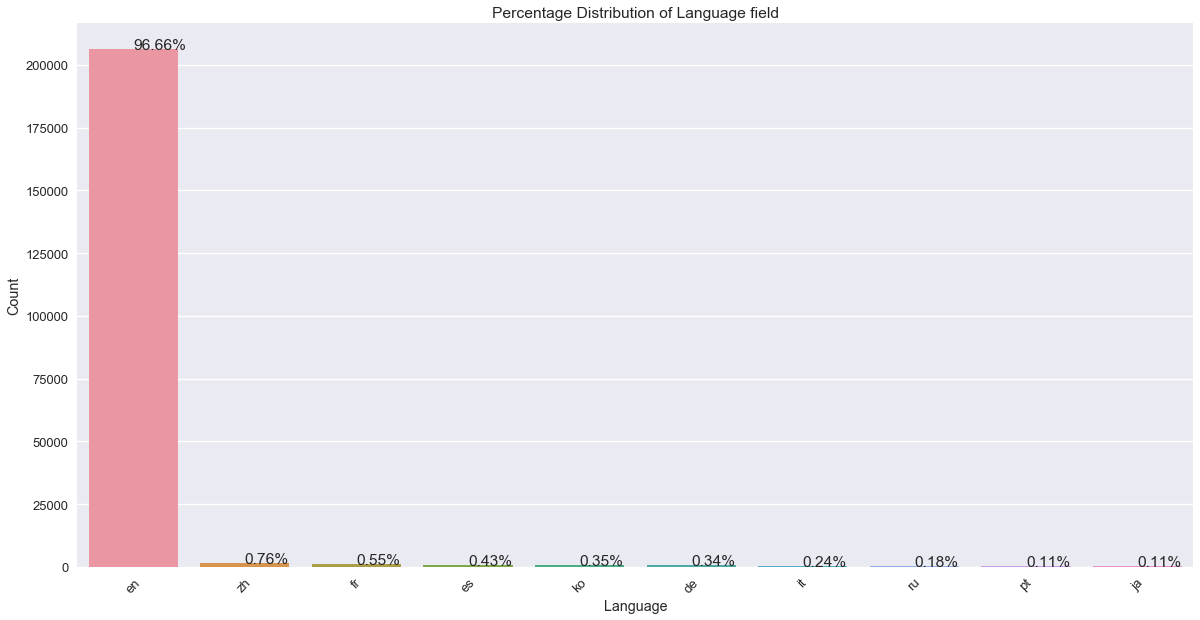

In [125]:
#Plotting Language Field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('language', data = train_df,order = train_df['language'].value_counts().head(10).index)
for i in range(10):
    range_count = language[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Language field')
plt.show()

###### Majority of users <b>(96.66%)</b> have english as their language. Since the data is from US therefore such a behaviour is quite expected as a majority population of that country identify english as their primary language.

##### 4. Analysing the 'affiliate_channel' Field :

In [126]:
print('Total unique values in affiliate_channel field :')
affiliate_channel = train_df['affiliate_channel'].value_counts()
print(affiliate_channel)

Total unique values in affiliate_channel field :
direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64


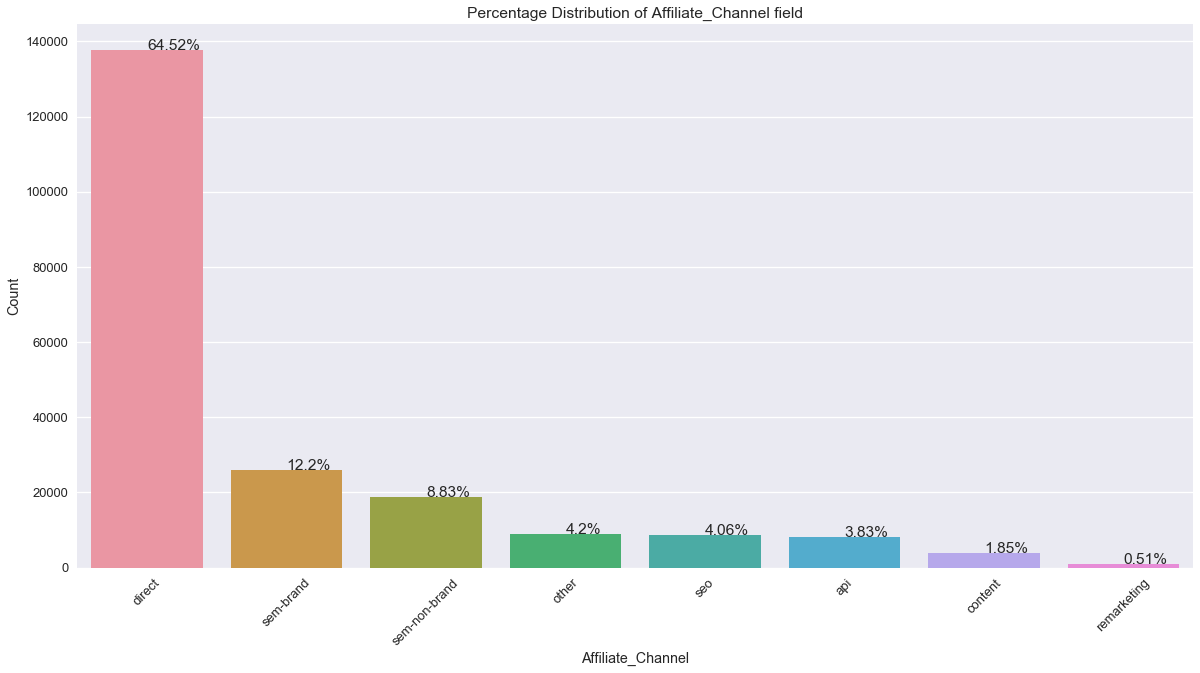

In [127]:
#Plotting the 'affiliate_channel' field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('affiliate_channel', data = train_df,order = train_df['affiliate_channel'].value_counts().index)
for i in range(affiliate_channel.shape[0]):
    range_count = affiliate_channel[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Affiliate_Channel')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Affiliate_Channel field')
plt.show()

This field explains what kind of paid marketing is used to reach the users i.e. what are the different channels/categories that are used. Among the <b>8</b> different categories, <b>'direct'</b> is the most useful as it reached the majority of the users <b>(64.52%)</b>. There is a sharp fall in the percentage as we go to the second most-important category 'semi-brand' that reached an approx <b>12.2%</b> users. 

<b>'content'</b> and <b>'remarketing'</b> have reached a very small percentage of users i.e 1.85% and 0.51% respectively. These are not much useful as a channel to market the application. They should either be dropped to save the cost of marketing or be improved so that it can reach more users.

##### 5. Analysing the 'affiliate_provider' field :

In [128]:
print('Total unique values in affiliate_provider field :')
affiliate_provider = train_df['affiliate_provider'].value_counts()
print(affiliate_provider)

Total unique values in affiliate_provider field :
direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
email-marketing           166
naver                      52
baidu                      29
yandex                     17
wayn                        8
daum                        1
Name: affiliate_provider, dtype: int64


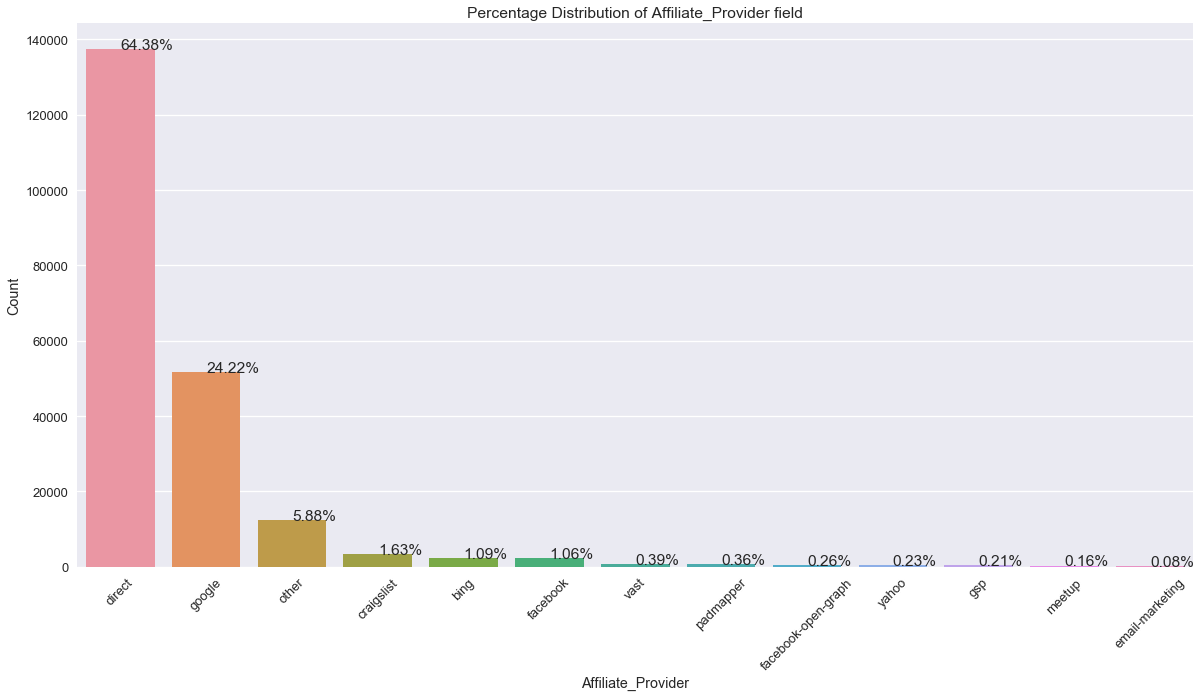

In [129]:
#https://matplotlib.org/3.1.1/gallery/ticks_and_spines/ticklabels_rotation.html

#Plotting the 'affiliate_provider' field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('affiliate_provider', data = train_df,order = train_df['affiliate_provider'].value_counts().head(13).index)
for i in range(13):
    range_count = affiliate_provider[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Affiliate_Provider')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Percentage Distribution of Affiliate_Provider field')
plt.show()

As seen in the earlier plot, a majority of the accounts there are reached <b>(64.38%)</b> are through <b>'basic'</b> channel. Other than that, <b>'google'</b> is also an important channel as it managed to reach a considerable percentage of accounts (24.22%).

<b>'meetup'</b> and <b>'email-marketing'</b> are not much useful as it reached an only 0.16% and 0.08% respectively. They should either be dropped to save the cost of marketing or be improved so that it can reach more users.

##### 6. Analysing the 'first_affiliate_tracked' field :

In [130]:
print('Total unique values in first_affiliate_tracked field :')
first_affiliate_tracked = train_df['first_affiliate_tracked'].value_counts()
print(first_affiliate_tracked)

Total unique values in first_affiliate_tracked field :
untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64


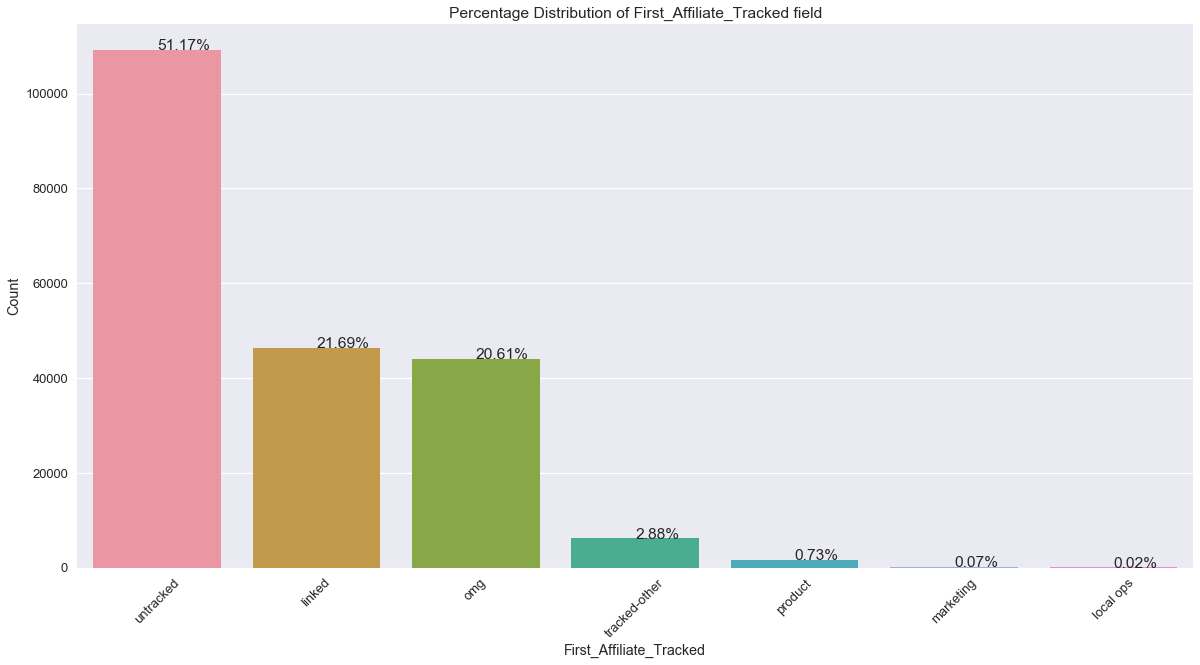

In [131]:
#Plotting the 'first_affiliate_tracked' field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('first_affiliate_tracked', data = train_df,order = train_df['first_affiliate_tracked'].value_counts().index)
for i in range(first_affiliate_tracked.shape[0]):
    range_count = first_affiliate_tracked[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('First_Affiliate_Tracked')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of First_Affiliate_Tracked field')
plt.show()

This field shows the first marketing the user interacted with before signing up. Majority of the users <b>(51.17%)</b> are <b>'untracked'</b> that is the first marketing channel that reached the user is not known. 

<b>'marketing'</b> and <b>'local ops'</b> are not much useful channels as it reached an only 0.07% and 0.02% respectively. They should either be dropped to save the cost of marketing or be improved so that it can reach more users.

##### 7. Analysing the 'signup_app' field :

In [132]:
print('Total unique values in signup_app field :')
signup_app = train_df['signup_app'].value_counts()
print(signup_app)

Total unique values in signup_app field :
Web        182717
iOS         19019
Moweb        6261
Android      5454
Name: signup_app, dtype: int64


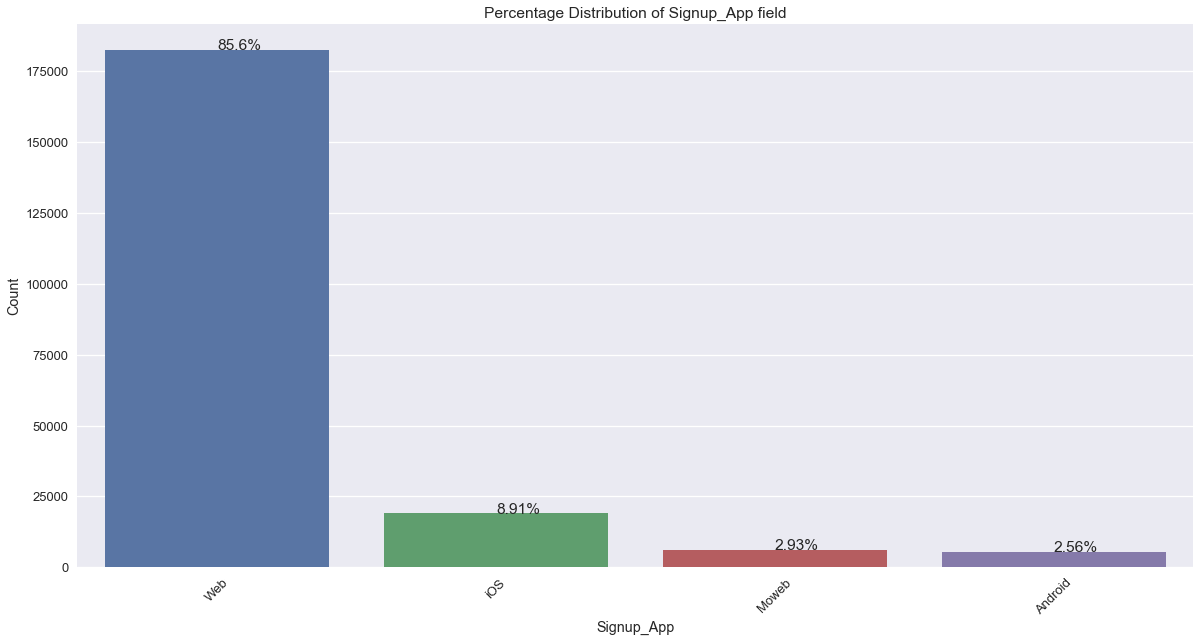

In [133]:
#Plotting the 'signup_app' field:

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('signup_app', data = train_df,order = train_df['signup_app'].value_counts().index)
for i in range(signup_app.shape[0]):
    range_count = signup_app[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Signup_App')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Signup_App field')
plt.show()

Majority of the users <b>(85.6%)</b> used <b>'Web'</b> to create the account. Among the remaining, <b>'iOS'</b> is marginally more used <b>(approx (5.98%) more)</b> than <b>'Moweb'</b> and <b>'Android'</b>.
    
<b>'Moweb'</b> and <b>'Android'</b> are not much popular apps to signup as it is used by an only 2.93% and 2.56% respectively of the users.

##### 8. Analysing the 'first_device_type' field :

In [134]:
print('Total unique values in first_device_type field :')
first_device_type = train_df['first_device_type'].value_counts()
print(first_device_type)

Total unique values in first_device_type field :
Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64


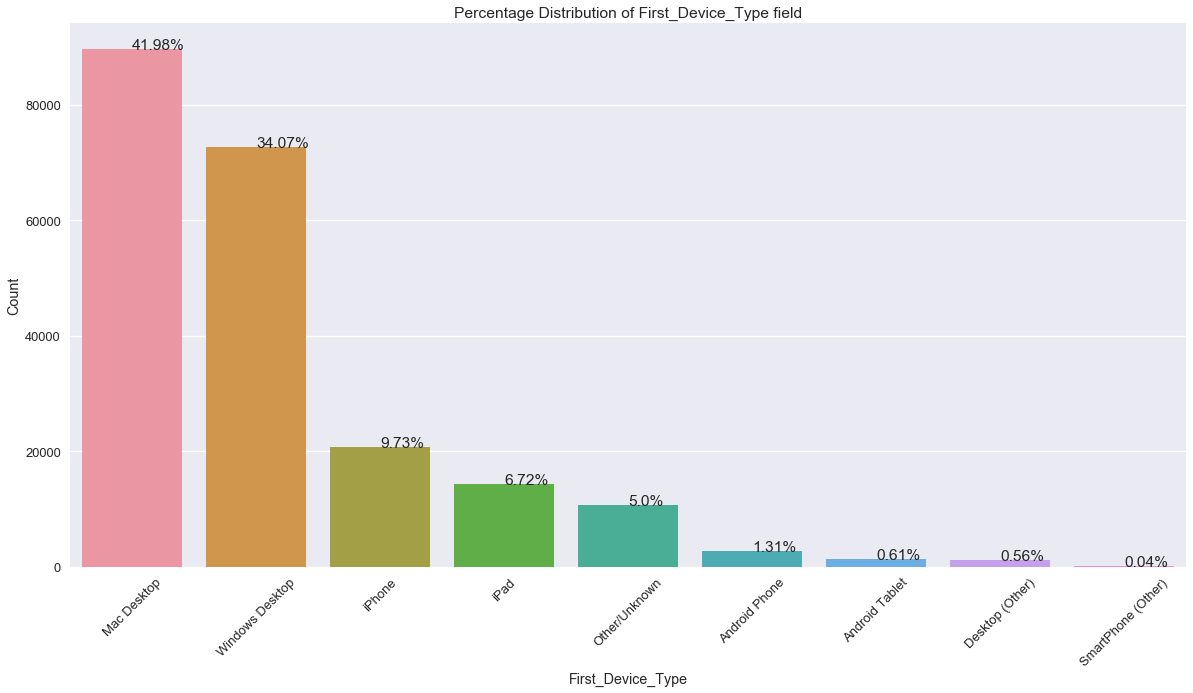

In [135]:
#Plotting the 'first_device_type' field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('first_device_type', data = train_df,order = train_df['first_device_type'].value_counts().index)
for i in range(first_device_type.shape[0]):
    range_count = first_device_type[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('First_Device_Type')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of First_Device_Type field')
plt.show()

Most popular device that is used to create an account is <b>'Mac Desktop</b> that is used by <b>41.98%</b> of the customers. It is closely followed by <b>'Windows Desktop'</b> with 34.07% of customers. 

Among the remaining categories, <b>'iPhone'</b> is <i>more popular</i> than <b>'Android Phone'</b> in the mobile domain. Similarly, <b>'iPad'</b> is <i>more popular</i> than <b>'Android Tablet'</b> in the tablet domain.

Overall we can conclude from this plot that Apple products are more popular than Android ones across all categories (desktop,mobile,tablet).

##### 9. Analysing the 'first_browser' field :

In [136]:
print('Total unique values in first_browser field :')
first_browser = train_df['first_browser'].value_counts()
print(first_browser)

Total unique values in first_browser field :
Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
IE Mobile                  36
Apple Mail                 36
Sogou Explorer             33
Mobile Firefox             30
SiteKiosk                  24
RockMelt                   24
Iron                       17
IceWeasel                  13
Pale Moon                  12
Yandex.Browser             11
SeaMonkey                  11
CometBird                  11
Camino                      9
TenFourFox                  8
CoolNovo                    6
wOSBrowser                  6
Avant Browser               4
Opera Mini               

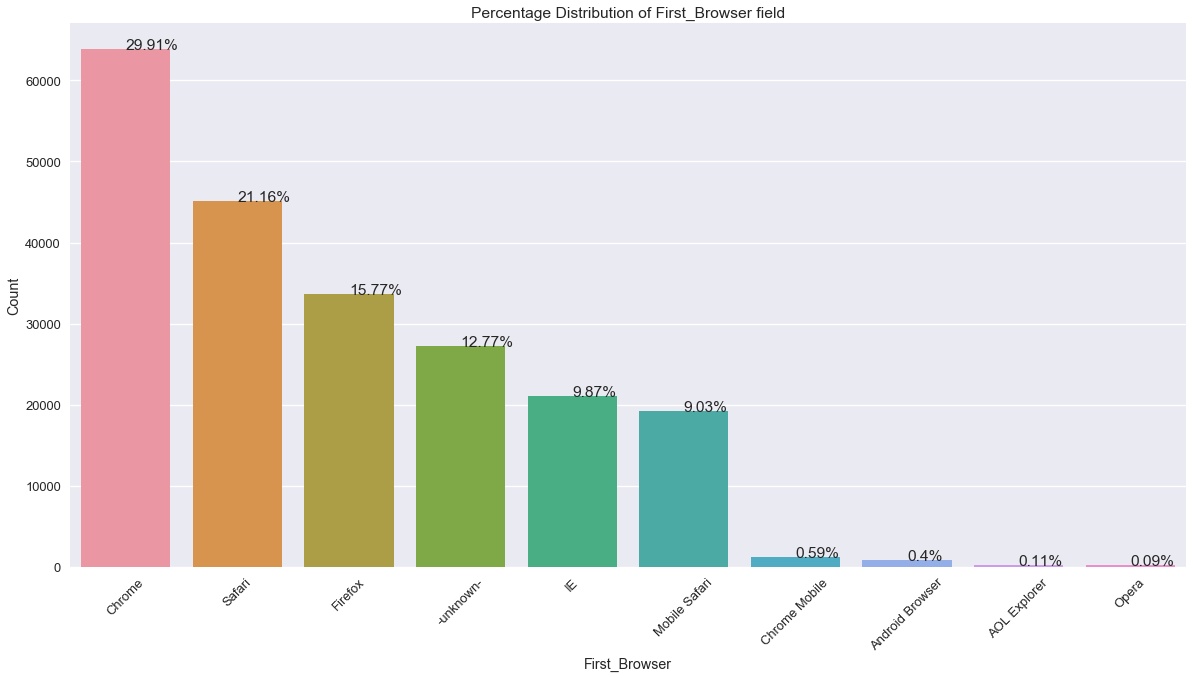

In [137]:
#Plotting the 'first_browser' field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('first_browser', data = train_df,order = train_df['first_browser'].value_counts().head(10).index)
for i in range(10):
    range_count = first_browser[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('First_Browser')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of First_Browser field')
plt.show()

This field tracks the first browser that the customer used to access the application. A large share <b>(29.91%)</b> is taken up by <b>'Chrome Browser'</b> followed by <b>'Safari'</b> at <b>21.16%</b> and by <b>'Firefox'</b> at <b>15.77%</b>.

From the previous plot it is known that <b>'Mac Desktop'</b> is the most popular device among the users. From this plot it is known that a large population of the customer prefered 'Chrome' as their browser even on their Apple products instead of Apple's own browser 'Safari'.

Another interesting fact is that for a considerable percentage <b>(12.77%)</b> of customer the first browser is not known.

##### 10. Analysing the 'country_destination' (target) field :

In [138]:
print('Total unique values in country_destination field :')
country_destination= train_df['country_destination'].value_counts()
print(country_destination)

Total unique values in country_destination field :
NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64


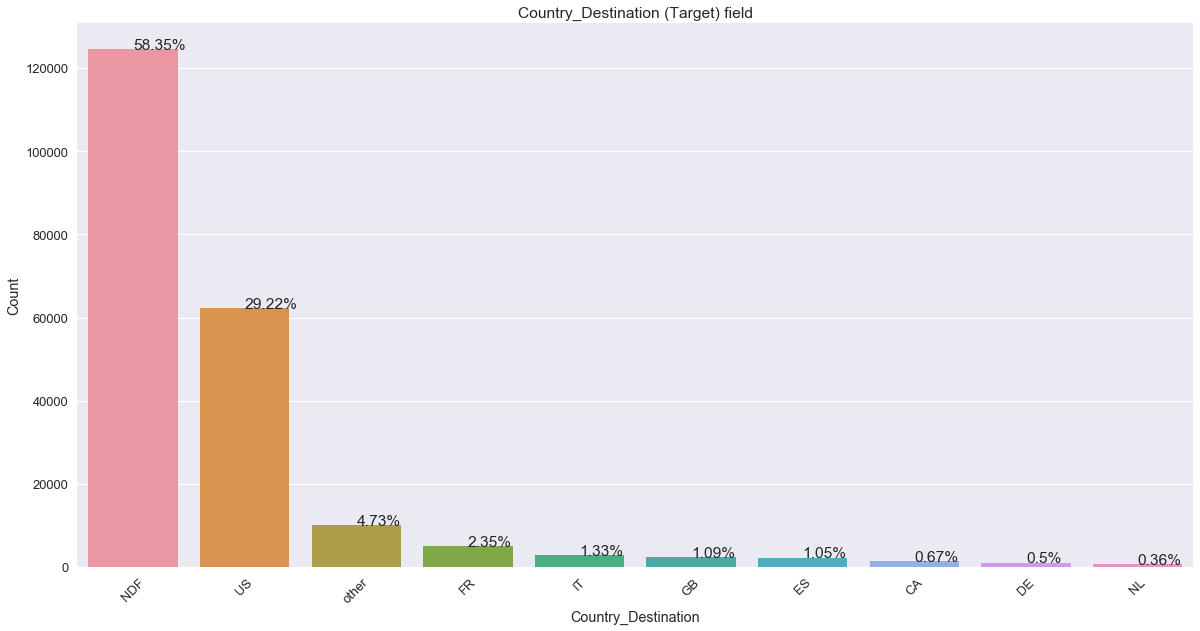

In [139]:
#Plotting the 'country_destination' field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('country_destination', data = train_df,order = train_df['country_destination'].value_counts().head(10).index)
for i in range(10):
    range_count = country_destination[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Country_Destination')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Country_Destination (Target) field')
plt.show()

The dataset is highly imbalanced. Majority of the customers <b>(58.35%)</b> has not made a booking. Among those that have, a large share of users <b>(29.22%)</b> booked for a destination in <b>'US'</b>. 

Among the countries given outside of US, <b>France ('FR')</b> has a high share of <b>2.35%</b>.
Also, a considerable percent of users <b>(4.73%)</b> travelled to a destination not present among the options given.

##### 11. Analysing the 'signup_flow' field :

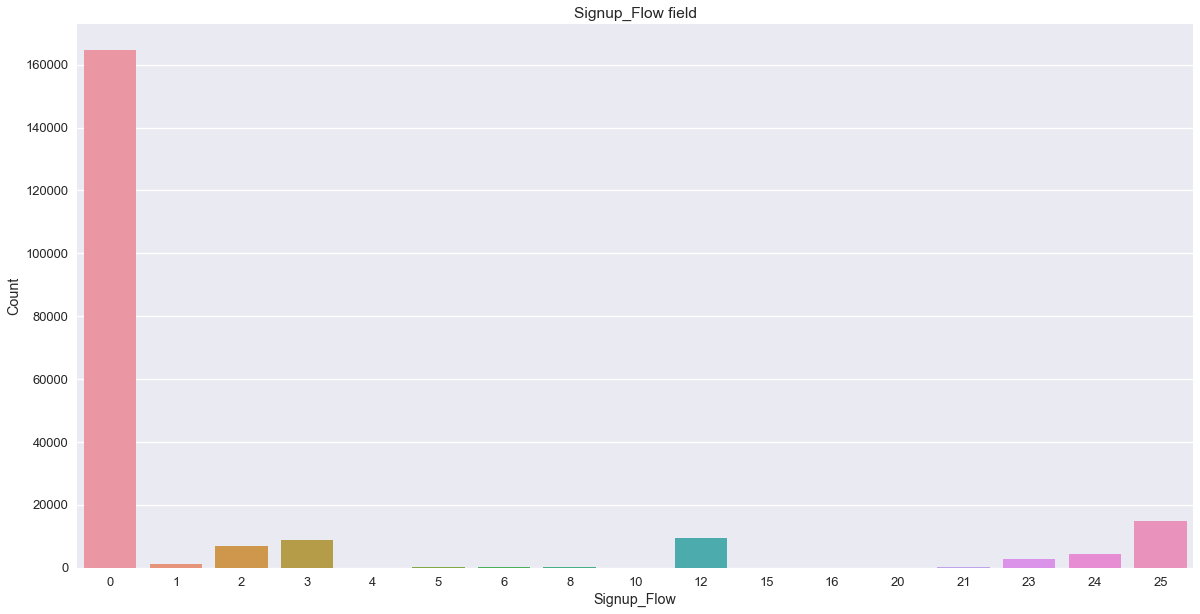

In [141]:
#Plotting the 'signup_flow' field :

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('signup_flow', data = train_df)
plt.xlabel('Signup_Flow')
plt.ylabel('Count')
plt.title('Signup_Flow field')
plt.show()

This field shows the page a user came to signup up from. Nearly <b>90%</b> users signed up from the page 0. So, it seems to bethe most important page.

Also, apart from 2,3,12,23,24 and 25 rest all are nearly negligible.

###### 12. Analysing the 'date_account_created' field :

###### Breaking the date in day , month and year fields :

###### 12.1. Analysing the 'account_created_day' field :

In [89]:
#https://stackoverflow.com/questions/36341484/get-day-name-from-weekday-int/36341648

# Breaking the day in name format just for visualization.

train_df['date_account_created'] = pd.to_datetime(train_df['date_account_created'])
train_df['account_created_day'] = train_df['date_account_created'].dt.strftime("%a")

In [95]:
print('Count of accounts created per day of the week :')
account_created_day = train_df['account_created_day'].value_counts()
account_created_day

Count of accounts created per day of the week :


Tue    35085
Wed    34087
Mon    32862
Thu    32570
Fri    29741
Sun    24568
Sat    24538
Name: account_created_day, dtype: int64

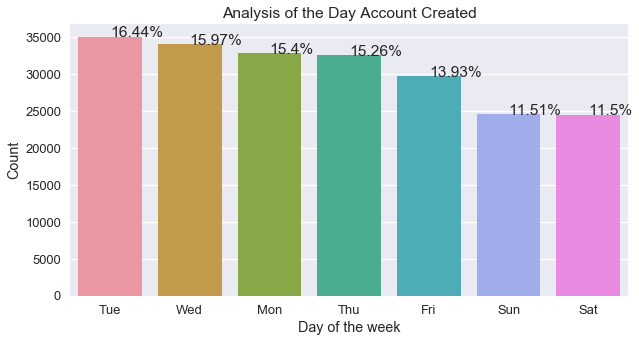

In [94]:
#Plotting the 'account_created_day' field :

plt.figure(figsize=(10,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('account_created_day', data = train_df,order = train_df['account_created_day'].value_counts().index)
for i in range(account_created_day.shape[0]):
    range_count = account_created_day[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Day of the week')
plt.ylabel('Count')
plt.title('Analysis of the Day Account Created')
plt.show()

<b>Tuesday</b> is the most popular day in the week with <b>16.44%</b> of accounts being created on that day , closely followed by <b>Wednesday</b> at <b>15.97%</b>. 

Also, weekdays are more popular than the weekends. The reason might be that in weekends people generally go out to spend time with family or friends and so is less likely to plan anything over internet. So, any marketing strategy targeting the weekdays might be more useful.

###### Now breaking the 'date_account_created' field in a format to be used for modelling ;

In [468]:
train_df['date_account_created'] = pd.to_datetime(train_df['date_account_created'])
train_df['account_created_day'] = train_df['date_account_created'].dt.weekday
train_df['account_created_month'] = train_df['date_account_created'].dt.month
train_df['account_created_year'] = train_df['date_account_created'].dt.year

###### 12.2. Analysing the 'account_created_month' field :

In [528]:
print('Total unique values in account_created_month field :')
account_created_month= train_df['account_created_month'].value_counts()
print(account_created_month)

Total unique values in account_created_month field :
6     27422
5     25912
4     21867
3     20325
1     17495
2     16582
9     15395
8     14611
7     13832
10    13476
12    13405
11    13129
Name: account_created_month, dtype: int64


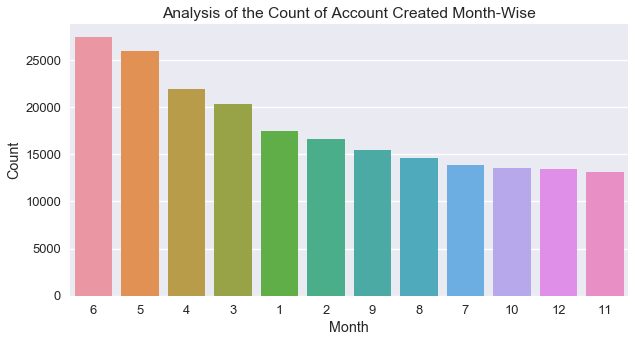

In [544]:

plt.figure(figsize=(10,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('account_created_month', data = train_df,order = train_df['account_created_month'].value_counts().index)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Analysis of the Count of Account Created Month-Wise')
plt.show()

<b>'June' (06)</b> is the most favourable month among the customers to create an account closely followed by <b>'May' (05)</b>. 

Least number of accounts are created during <b>'November' (11)</b> and <b>'Decembor' (12)</b>. That time is a hoilday period for majority of people around the world so they might be actually travelling during the time.

##### 12.3. Analysing the 'account_created_year' field :

In [4]:
print('Total unique values in account_created_year field :')
account_created_year= train_df['account_created_year'].value_counts()
print(account_created_year)

Total unique values in account_created_year field :
2013    82960
2014    76466
2012    39462
2011    11775
2010     2788
Name: account_created_year, dtype: int64


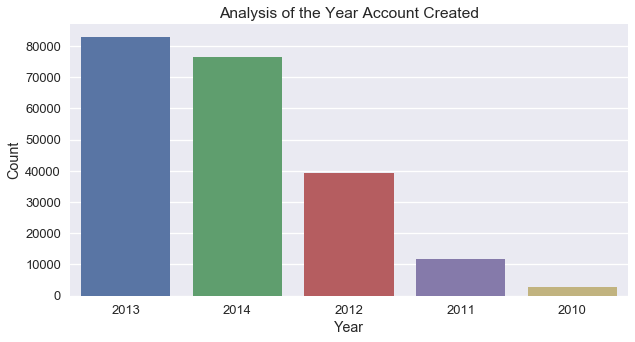

In [533]:
plt.figure(figsize=(10,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('account_created_year', data = train_df,order = train_df['account_created_year'].value_counts())
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Analysis of the Year Account Created')
plt.show()

The number of accounts created has increased over the years from 2010 to 2014. For 2014 only the accounts created between January to June is given in train dataset. 

##### 12.4. Analysing the Month and Year wise increment  to check seasonal variability :

In [537]:
#Grouping the 'account_created_month' and 'account_created_year' field to check the seasonal variability :

train_df1= train_df.groupby(['account_created_month','account_created_year']).count()
train_df1.reset_index(inplace=True)

In [217]:
train_df1.head(10)

,account_created_month,account_created_year,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day
0,1,2010,61,61,61,61,61,61,61,61,61,61,45,61,61,61,61,61
1,1,2011,316,316,316,316,316,316,316,316,316,316,233,316,316,316,316,316
2,1,2012,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1325,1589,1589,1589,1589,1589
3,1,2013,4418,4418,4418,4418,4418,4418,4418,4418,4418,4418,4405,4418,4418,4418,4418,4418
4,1,2014,11111,11111,11111,11111,11111,11111,11111,11111,11111,11111,10823,11111,11111,11111,11111,11111
5,2,2010,102,102,102,102,102,102,102,102,102,102,69,102,102,102,102,102
6,2,2011,362,362,362,362,362,362,362,362,362,362,278,362,362,362,362,362
7,2,2012,1789,1789,1789,1789,1789,1789,1789,1789,1789,1789,1488,1789,1789,1789,1789,1789
8,2,2013,4362,4362,4362,4362,4362,4362,4362,4362,4362,4362,4351,4362,4362,4362,4362,4362
9,2,2014,9967,9967,9967,9967,9967,9967,9967,9967,9967,9967,9736,9967,9967,9967,9967,9967


Text(0,0.5,'Counts')

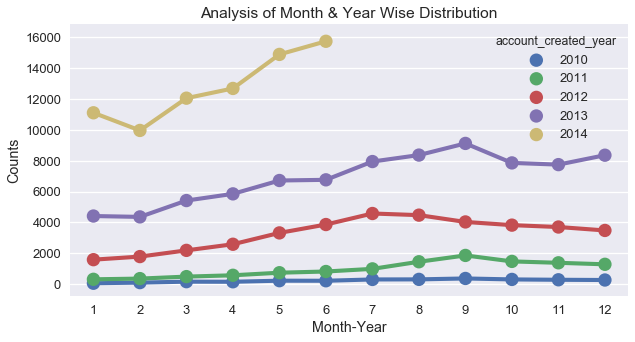

In [543]:
#Plotting the counts for month over year:

plt.figure(figsize=(10,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.pointplot(data=train_df1,x='account_created_month',y='country_destination',hue='account_created_year');
plt.title('Analysis of Month & Year Wise Distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

For month April (04) and May (05) we see an increament in account creation for all the years. Similarly for months June (06) and July (07) we see such an increament. 

Months August (08) and September (09) saw an increament but only for years 2011 and 2013 while for 2012 we see a dip the number.

For year 2011, the least number of accounts are created on January and Febuary whereas the highest count is observed for the month September.

For year 2012, the least number of accounts are created again on January and Febuary whereas the highest count is observed for the months July and August.

For year 2013, the least number of accounts are created again on January and Febuary whereas the highest count is observed for the month September.

For year 2014 till June, the least number of accounts are created on Febuary whereas the highest count is observed for the month June. Also, compared to the other years , a considerable more number of accounts are created on 2014 for all the months.

##### 13. Analysing the 'age' field ;

In [143]:
train_df['age'].isnull().sum()

87990

A total of 87,990 users have not disclosed their age.

<Figure size 720x360 with 0 Axes>

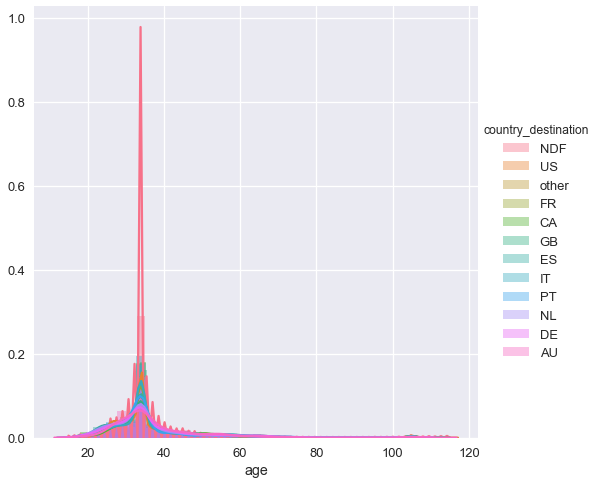

In [550]:
#Plotting 'age' with 'country_destination' field : 

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.FacetGrid(train_df,hue='country_destination',size=7).map(sns.distplot,'age').add_legend()
plt.show()

'age' alone is not a good feature to correctly classify the classes as the overlap between classes is quite large.


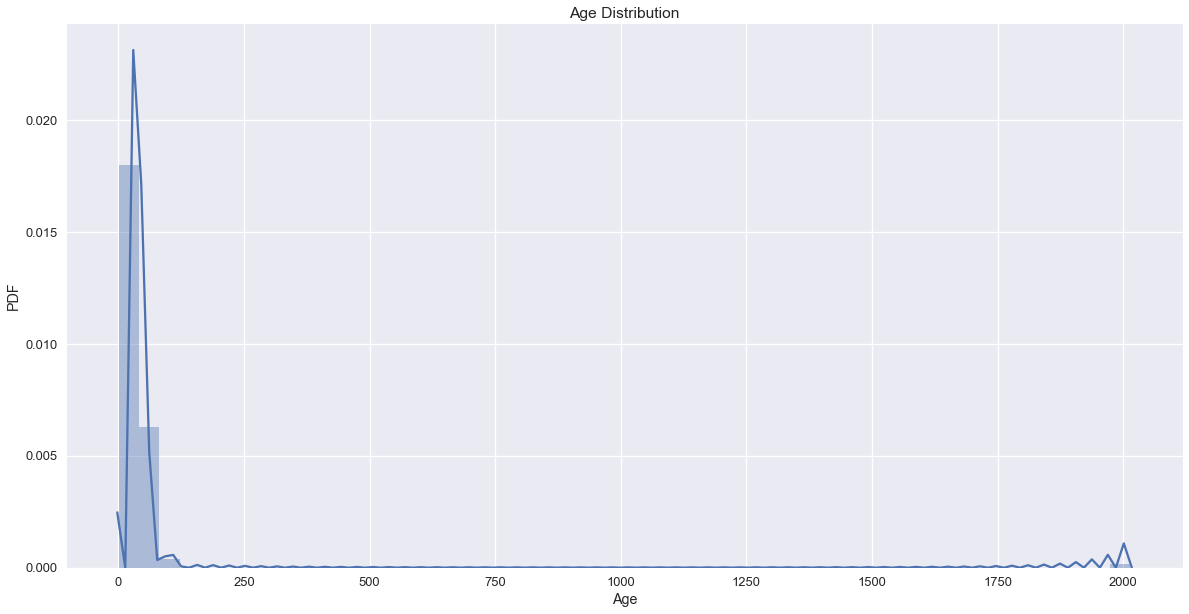

In [144]:
#Plotting the distribution for the 'age' field :

plt.figure(figsize = (20,10))
sns.set(style='darkgrid')
sns.set_context('talk')
sns.distplot(train_df['age'].dropna())
plt.xlabel('Age')
plt.ylabel('PDF')
plt.title('Age Distribution')
plt.show()

'age' field has very high outliers and so we need to tackle that first.

In [142]:
train_df['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

There are outliers both in the minimum value and in the maximum value as 1 year as age or 2014 years as age cannot be a feasible value.

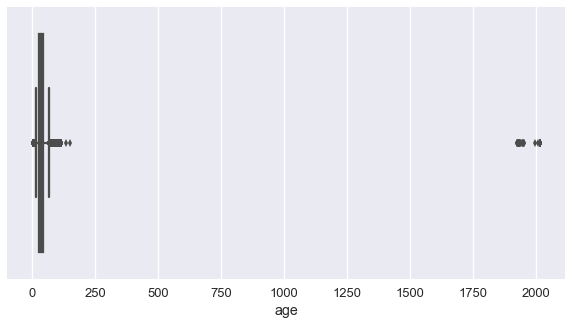

In [147]:
#Plotting the boxplot of 'age' to confirm the presence of outliers :

plt.figure(figsize=(10,5))
sns.set(style='darkgrid')
sns.set_context('talk')
sns.boxplot(train_df['age'].dropna())
plt.show()

This boxplot confirms the presence of outliers.

###### Checking the percentile values to detect the outlier in the minimum value :

In [148]:
for i in range(0,110,10):
    print('{} percentile value : {}'.format(i,np.percentile(train_df['age'].dropna(),i)))

0 percentile value : 1.0
10 percentile value : 25.0
20 percentile value : 27.0
30 percentile value : 29.0
40 percentile value : 32.0
50 percentile value : 34.0
60 percentile value : 36.0
70 percentile value : 40.0
80 percentile value : 46.0
90 percentile value : 56.0
100 percentile value : 2014.0


In [149]:
for i in range(0,11,1):
    print('{} percentile value : {}'.format(i,np.percentile(train_df['age'].dropna(),i)))

0 percentile value : 1.0
1 percentile value : 19.0
2 percentile value : 21.0
3 percentile value : 22.0
4 percentile value : 22.0
5 percentile value : 23.0
6 percentile value : 23.0
7 percentile value : 24.0
8 percentile value : 24.0
9 percentile value : 25.0
10 percentile value : 25.0


In [150]:
for i in ([0, 0.1, 0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    print('{} percentile value : {}'.format(i,np.percentile(train_df['age'].dropna(),i)))

0 percentile value : 1.0
0.1 percentile value : 17.0
0.2 percentile value : 18.0
0.3 percentile value : 18.0
0.4 percentile value : 18.0
0.5 percentile value : 18.0
0.6 percentile value : 18.0
0.7 percentile value : 19.0
0.8 percentile value : 19.0
0.9 percentile value : 19.0
1 percentile value : 19.0


In [151]:
for i in ([0, 0.01, 0.02, 0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]):
    print('{} percentile value : {}'.format(i,np.percentile(train_df['age'].dropna(),i)))

0 percentile value : 1.0
0.01 percentile value : 5.0
0.02 percentile value : 5.0
0.03 percentile value : 5.0
0.04 percentile value : 5.0
0.05 percentile value : 15.0
0.06 percentile value : 16.0
0.07 percentile value : 16.0
0.08 percentile value : 17.0
0.09 percentile value : 17.0
0.1 percentile value : 17.0


<b>0.04</b> percentile value is <b>5.0</b> and <b>0.05</b> percentile value is <b>15.0</b>. This shows that anything <i>below 0.05</i> percentile value is an <i>outlier</i>. So we are taking the <b>minimum permissible value for age as 15.0</b> and anything else than this is handled through processing as mentioned below.

###### Checking the percentile values to detect the outlier in the maximum value :

In [152]:
for i in range(90,101,1):
    print('{} percentile value : {}'.format(i,np.percentile(train_df['age'].dropna(),i)))

90 percentile value : 56.0
91 percentile value : 57.0
92 percentile value : 58.0
93 percentile value : 60.0
94 percentile value : 62.0
95 percentile value : 64.0
96 percentile value : 67.0
97 percentile value : 71.0
98 percentile value : 93.0
99 percentile value : 105.0
100 percentile value : 2014.0


In [153]:
for i in np.arange(99,100,0.1):
    print('{} percentile value : {}'.format(i,np.percentile(train_df['age'].dropna(),i)))

99.0 percentile value : 105.0
99.1 percentile value : 105.0
99.19999999999999 percentile value : 109.0
99.29999999999998 percentile value : 110.0
99.39999999999998 percentile value : 1949.7199999999284
99.49999999999997 percentile value : 2014.0
99.59999999999997 percentile value : 2014.0
99.69999999999996 percentile value : 2014.0
99.79999999999995 percentile value : 2014.0
99.89999999999995 percentile value : 2014.0


99.29 percentile value is 110.0 and 99.39 percentile value is 1949(approx). So this shows that anything <i>above 99.29</i> percentile value is an outlier and is handled through processing as mentioned below.

In [236]:
train_df['age'].isnull().sum()

87990

In [469]:
print('Median Age : ', train_df['age'].median())

Median Age :  34.0


Median value for 'age' is 34.

We see some people have given age values as 19xx or 20xx. 
 
<b><i>We can assume that those who have given 19xx as age have mistakenly put their year of birth instead of their age. </i></b>
 
<b><i>Those who have given 20xx as age have inputted any arbitary value as their age.</i></b>

<b>We are processing the values of 'age' field using any of the following 4 cases :</b>

1. Fill the <b>null</b> values with the <b>median</b> value i.e. 34.



2. We replace any value less than the minimum age found i.e. 15.0 or any value more than 2007 with the median value i.e. 34.



3. We keep any value between 15.0 and 117.0 (age of the oldest person alive today) as it is.



4. For age that is <b>greater than 117.0</b>  and <b>less than 2007</b>, we assume that the user has mistakenly inputted their year of birth instead of age. So we substract that value from the 'account_created_year' field value to get their age on the day they created the account.

In [470]:
#Replacing the null values in 'age' field with median value :

train_df['age'] = train_df['age'].fillna(train_df['age'].median())

In [471]:
print('Max Age before processing : ', train_df['age'].max())

Max Age before processing :  2014.0


In [472]:
#Function to replace any value of age less than 15 or greater than 2007 with the median age

def func_age_imput_median(age):
    
    """
    Function to replace any value of age ;ess than 15 or greater than 2007 with the median age
    
    parameters: age 
    
    returns : age  
    
    """
    
    if age < 15.0 or age > 2007.0:
        return 34.0
    else:
        return age

In [473]:
train_df['age'] = train_df['age'].apply(func_age_imput_median)
print('Max Age After Median Imputation : ' ,train_df['age'].max())

Max Age After Median Imputation :  1995.0


We have been able to decrease the maximum age from 2014 to 1995 with this step of processing.

In [474]:
#Checking with the condition given in point 4 :

x = train_df[(train_df['age'] > 117) & (train_df['age'] < 2007)]
x.shape

(31, 19)

In [475]:
x

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,account_created_year
41046,rm0p78riic,2012-09-15,20120915182743,2012-09-16,FEMALE,1949.0,facebook,12,en,api,other,untracked,Moweb,Windows Desktop,Chrome,US,5,9,2012
55474,lxfw8qaa2e,2013-01-11,20130111014721,NaN,MALE,1931.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF,4,1,2013
59537,lkgth08quo,2013-02-07,20130207231010,2013-02-08,MALE,1932.0,facebook,12,en,api,other,untracked,Moweb,iPhone,-unknown-,US,3,2,2013
67223,n87aqj7mf0,2013-03-25,20130325205715,NaN,MALE,1932.0,facebook,12,en,api,other,untracked,Moweb,Windows Desktop,Chrome,NDF,0,3,2013
67610,nc8fk6z69z,2013-03-27,20130327211209,2013-04-23,MALE,1932.0,facebook,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,US,2,3,2013
81999,alikwmur4b,2013-06-06,20130606035155,NaN,MALE,1928.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,3,6,2013
102044,f03qb47hvh,2013-08-24,20130824181551,2013-09-02,MALE,1936.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome,US,5,8,2013
104695,ilbzj6qgjl,2013-09-03,20130903233759,NaN,FEMALE,1933.0,basic,24,en,direct,direct,untracked,Moweb,Other/Unknown,-unknown-,NDF,1,9,2013
114377,xr4b6b4v1p,2013-10-05,20131005022844,2013-10-10,MALE,1935.0,basic,12,en,api,other,untracked,Android,Other/Unknown,-unknown-,US,5,10,2013
114599,92k02vn9xz,2013-10-06,20131006031210,NaN,MALE,1925.0,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,6,10,2013


We see there are 2 records with age 150 and 132 value. These values satisfy the condition 4 mentioned above but we cannot substract this value from the year of account creation as that will lead to corrupt values. 


So we are manually replacing these values with the median.

In [476]:
train_df['age'][144698] = 34
train_df['age'][156511] = 34

In [477]:
x = train_df[(train_df['age'] > 117) & (train_df['age'] < 2007)]
x.shape

(29, 19)

In [493]:
def func_age_imput_year(age,year):
    
    """
    Function to check if age is between 117 and 2007. If true, it will substract that age value from the year of account 
    creation to get the exact age of the user on the year he created the account.
        
    parameters: age,account_created_year 
    
    returns : age  
    
    """
    
    res = 0
    if age > 117.0 and age <=2007.0:
        res = year-age
        return res 
    else:
        return age

In [494]:
train_df['age'] = train_df.apply(lambda x: func_age_imput_year(x['age'], x['account_created_year']), axis=1)

In [505]:
print('Max Age After Year Imputation : ' ,train_df['age'].max())

Max Age After Year Imputation :  115.0


We are finally able to reduce the maximum value of the 'age' field to a value that is possible. Also the previous percentile check confirmed that 115.0 age is not an outlier.

In [495]:
train_df['age'].describe()

count    213451.000000
mean         36.006526
std          10.794212
min          15.000000
25%          32.000000
50%          34.000000
75%          35.000000
max         115.000000
Name: age1, dtype: float64

The statistics for 'age' seems far better now.

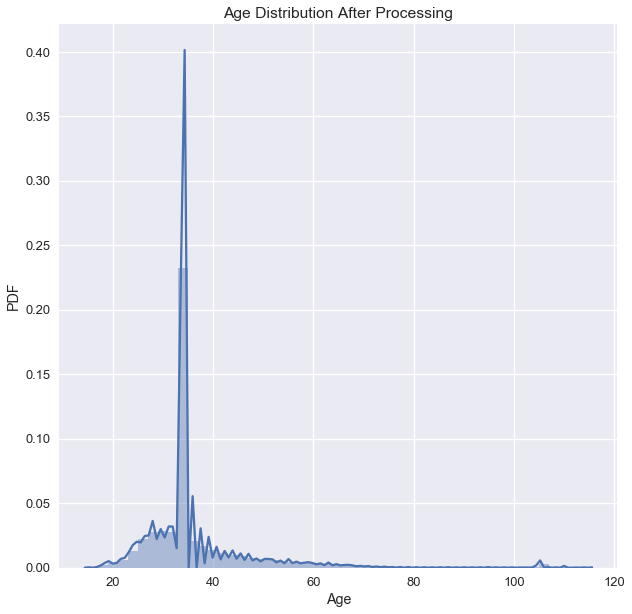

In [509]:
#Plotting the 'age' distribution after processing the outliers :

plt.figure(figsize = (10,10))
sns.set(style='darkgrid')
sns.set_context('talk')
sns.distplot(train_df['age'].dropna())
plt.xlabel('Age')
plt.ylabel('PDF')
plt.title('Age Distribution After Processing')
plt.show()

The histogram shows that for a majority of the users the age lies below 40 with the median age being 34. 

In [512]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,account_created_year
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,0,6,2010
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2,5,2011
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,1,9,2010
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0,12,2011
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,1,9,2010


###### 14. Dropping the 'date_first_booking' field because for the test users anyway this field is completely empty.

In [513]:
train_df.drop('date_first_booking',axis = 1, inplace = True)

In [514]:
train_df.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,account_created_year
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,0,6,2010
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2,5,2011
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,1,9,2010
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0,12,2011
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,1,9,2010


###### Saving the dataset we got till now.

In [517]:
train_df.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\train_users_2.csv\train_users_2_preprocessed.csv', index=False) 

In [3]:
train_df = pd.read_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\train_users_2.csv\train_users_2_preprocessed.csv')
print('Shape of the Train Data : ',train_df.shape)
print('Columns of Train Data : ', train_df.columns)
train_df.head()

Shape of the Train Data :  (213451, 18)
Columns of Train Data :  Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'account_created_day', 'account_created_month', 'account_created_year'],
      dtype='object')


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,account_created_year
0,gxn3p5htnn,6/28/2010,2.009030e+13,-unknown-,34,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,0,6,2010
1,820tgsjxq7,5/25/2011,2.009050e+13,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2,5,2011
2,4ft3gnwmtx,9/28/2010,2.009060e+13,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,1,9,2010
3,bjjt8pjhuk,12/5/2011,2.009100e+13,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0,12,2011
4,87mebub9p4,9/14/2010,2.009120e+13,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,1,9,2010


### BIVARIATE ANALYSIS :

##### 1. Analysis of 'country_destination' and 'age' :

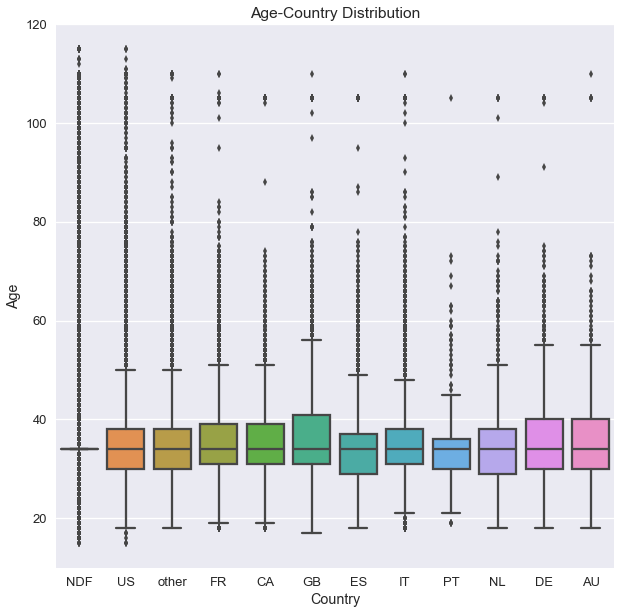

In [22]:
plt.figure(figsize=(10,10))
sns.set(style='darkgrid')
sns.set_context('talk')
sns.boxplot(x=train_df['country_destination'] , y=train_df['age'])
plt.xlabel('Country')
plt.ylabel('Age')
plt.title('Age-Country Distribution')
plt.show()

This bivariate analysis between <b>'country_destination'</b> and <b>'age'</b> shows the age distribution of users for different destinations chosen. 

For <b>'NDF'</b> the customers have a median age. This shows that the customers have not given their age as they are not serious about booking.

For <b>'GB'</b> the spread of the age of the customers is more than other destinations.

###### 2. Analysis of 'country_destination' and 'gender' :

In [34]:
train_df_dest_gender= train_df.groupby(['country_destination','gender']).count()
train_df_dest_gender.reset_index(inplace=True)

In [38]:
train_df_dest_gender.head()

,country_destination,gender,id,date_account_created,timestamp_first_active,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_created_day,account_created_month,account_created_year
0,AU,-unknown-,143,143,143,143,143,143,143,143,143,133,143,143,143,143,143,143
1,AU,FEMALE,207,207,207,207,207,207,207,207,207,205,207,207,207,207,207,207
2,AU,MALE,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188
3,AU,OTHER,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,CA,-unknown-,491,491,491,491,491,491,491,491,491,463,491,491,491,491,491,491


Text(0,0.5,'Counts')

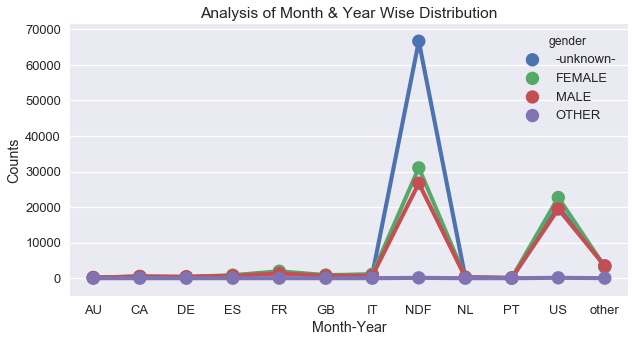

In [37]:
#Plotting the 'country_destination' and 'gender' :

plt.figure(figsize=(10,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.pointplot(data=train_df_dest_gender,x='country_destination',y='signup_method',hue='gender');
plt.title('Analysis of Month & Year Wise Distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

We see only for options <b>'NDF'</b> and <b>'US'</b> we have a generous count for different classes of gender. For other destinations there are not much visible differences in the count for different genders.

For <b>'NDF'</b> the gender for the majority customers is <b>'Unknown'</b>. Among those customers that have disclosed their genders, we see <b>'Female'</b> has a slight higher count than <b>'Male'</b>. 

We see a similar trend for <b>'US'</b> destination also. 

###### 3. Analysis of 'country_destination' and 'signup_method' :

Text(0.5,1,'Signup_Method - Destination Distribution')

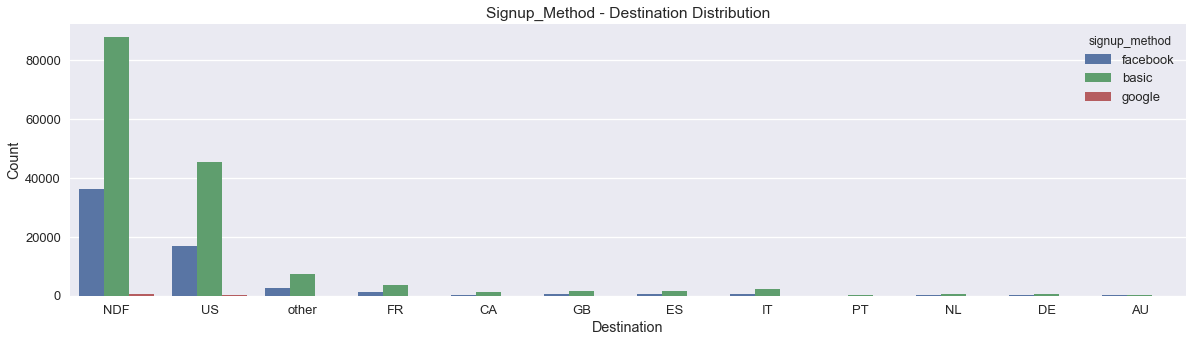

In [51]:
#Signup_Method - Destination Distribution Plot

plt.figure(figsize=(20,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot(data = train_df, x = 'country_destination',hue='signup_method')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Signup_Method - Destination Distribution')

For all the destinations we see the count for <b>'basic'</b> is more than any other options. Second to that we have <b>'Facebook'</b>.

'NDF', 'US', 'other' and 'FR' have some significant count for the different signup_methods.

###### 4. Analysis of 'country_destination' and 'affiliate_channel' :

Text(0.5,1,'Affiliate_Channel - Destination Distribution')

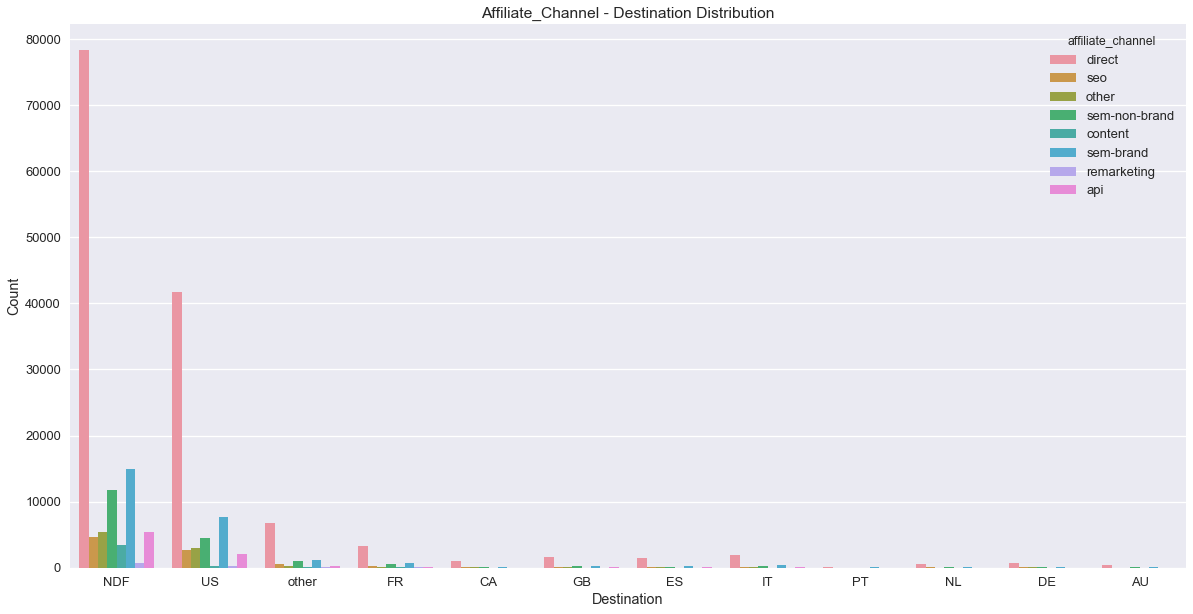

In [61]:
#Affiliate_Channel - Destination Distribution Plot

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot(data = train_df, x = 'country_destination',hue='affiliate_channel')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Affiliate_Channel - Destination Distribution')

<b>'direct'</b> has the highest count for all the destinations. After 'direct' we see <b>'semi-brand'</b> has the second-highest count across all the destinations.

We see the substantial count for different categories of 'affiliate_channel' only for 'NDF', 'US' and 'other' destination choices.

###### 5. Analysing the 'country_destination' and 'signup_app' :

Text(0.5,1,'Signup_App - Destination Distribution')

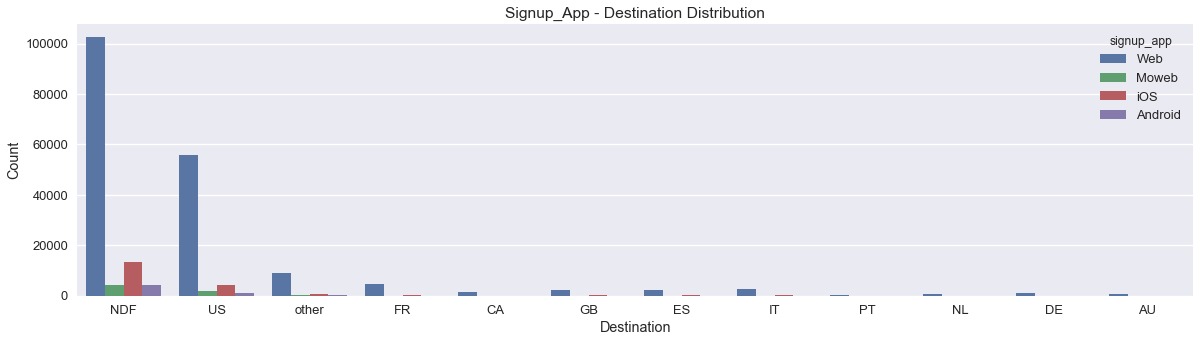

In [63]:
#Signup_App - Destination Distribution Plot

plt.figure(figsize=(20,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot(data = train_df, x = 'country_destination',hue='signup_app')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Signup_App - Destination Distribution')

As we have seen in univariate analysis of 'signup_app' field, <b>'Web'</b> is the most preferred option across all the destination options, followed by <b>'iOS'</b>.

###### 6. Analysing the 'country_destination' and 'first_device_type' :

Text(0.5,1,'First_Device_Type - Destination Distribution')

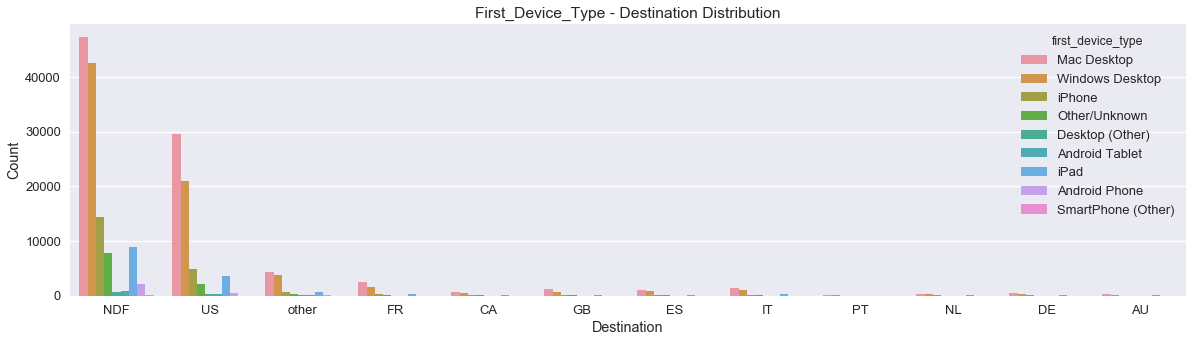

In [65]:
#First_Device_Type - Destination Distribution Plot

plt.figure(figsize=(20,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot(data = train_df, x = 'country_destination',hue='first_device_type')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('First_Device_Type - Destination Distribution')

Most popular device that is used to create an account is 'Mac Desktop' across all the destinations. It is closely followed by 'Windows Desktop'.

Among the remaining categories, 'iPhone' is more popular than 'Android Phone' in the mobile domain. Similarly, 'iPad' is more popular than 'Android Tablet' in the tablet domain.

Overall we can conclude from this plot that Apple products are more popular than Android ones across all categories (desktop,mobile,tablet) and for all destinations.

###### 7. Analysing the 'country_destination' and 'account_created_month'  :

Text(0.5,1,'Account_Created_Month - Destination Distribution')

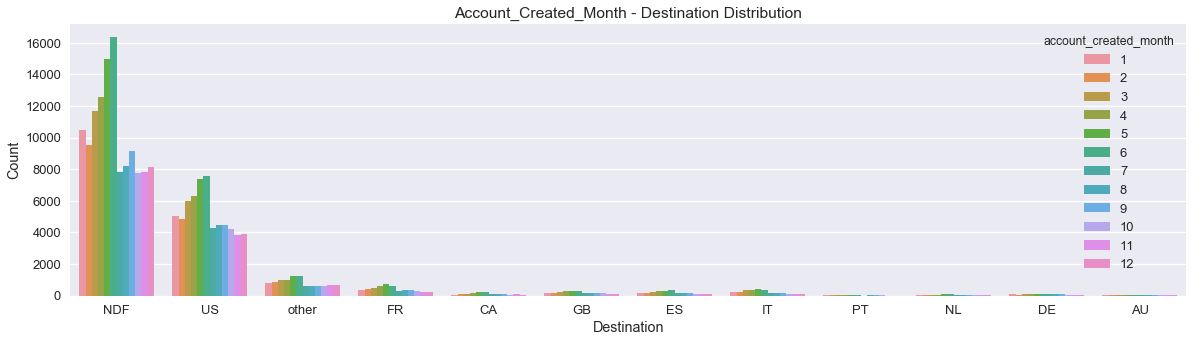

In [69]:
#Account_Created_Month - Destination Distribution Plot

plt.figure(figsize=(20,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot(data = train_df, x = 'country_destination',hue='account_created_month')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Account_Created_Month - Destination Distribution')

Most accounts are created on the month <b>'June' 06</b> for 'NDF' and 'US' destinations. 

Whereas, for <b>'other'</b>, equal number of accounts are created for <b>'May' 05</b> and <b>'June' 06</b> but the count of the total accounts created for 'other' is substantially lower than that for 'NDF' and 'US'.

For destination <b>'FR'</b>, we see that more accounts are created on <b>'May' 05</b> than any other months but the count for 'FR' is even less than that for 'other'.

The counts for the remaining destinations are way too less to derive any meaningful conclusions.

###### 8. Analysing the 'country_destination' and 'account_created_year' :

Text(0.5,1,'Account_Created_Year - Destination Distribution')

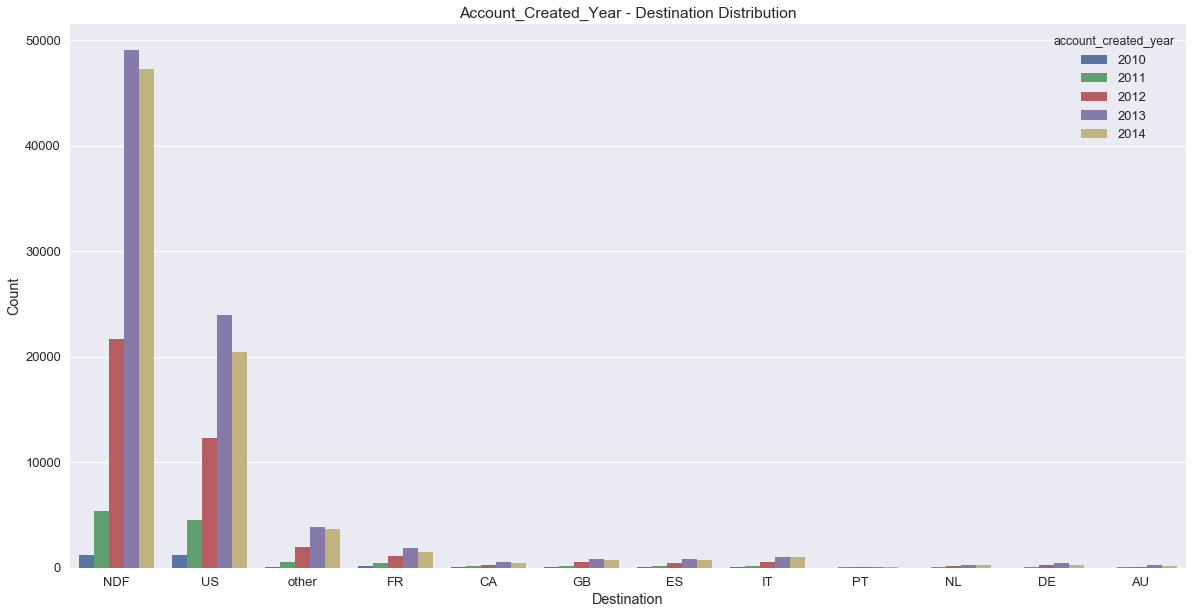

In [78]:
#Account_Created_Year - Destination Distribution Plot

plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot(data = train_df, x = 'country_destination',hue='account_created_year')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Account_Created_Year - Destination Distribution')

As seen in univariate analysis , the count of accounts created has increased year over year for all the destinations. But the <i>rate of increase</i> is <i>more</i> for 'NDF' and 'US' than the other destination choices.

### Multi-variate Analysis :

###### Analysing 'age', 'country_destination' and 'gender' :

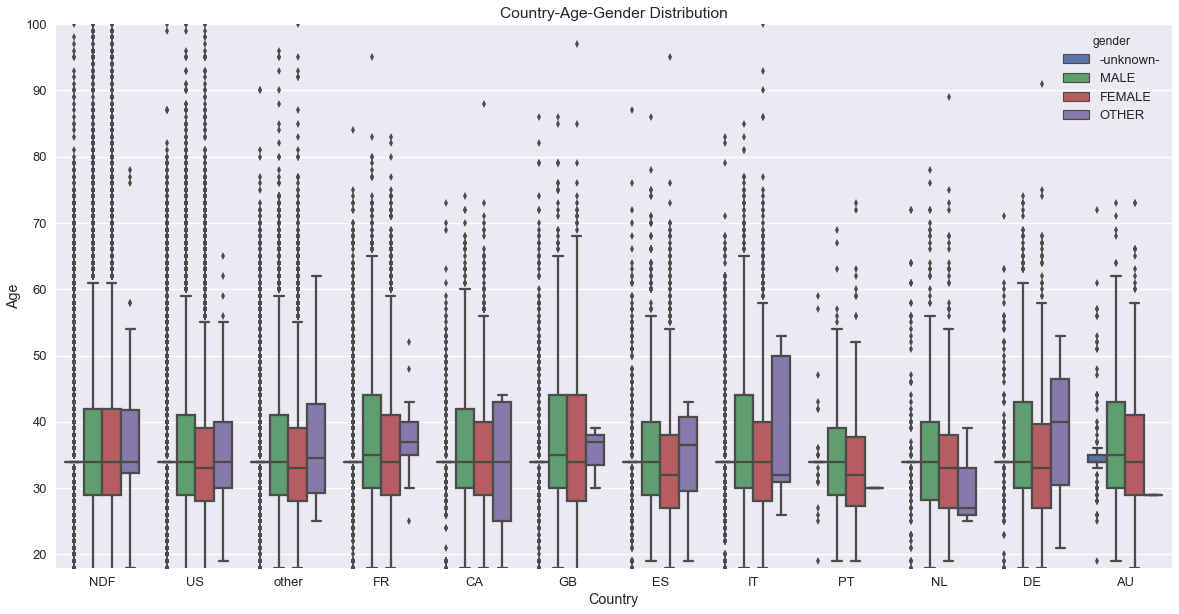

In [80]:
plt.figure(figsize=(20,10))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.boxplot(data=train_df, y = 'age',x='country_destination',hue='gender');
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age-Gender Distribution')

For <b>'NDF'</b> , we see that the 'age' distribution for both 'Male' and 'Female' gender is same. This is almost true for all other destinations also. 

But for <b>'other'</b> gender we see that there is <i>quite a variation</i> in the <i>spread</i> of 'age' variable across the different destinations. 

For example, the spread of 'age' for 'other' gender is very small for destinations like 'FR', 'GB' and 'NL'. On the other hand, it is quite large for 'CA', 'IT' and 'DE'.



### Reading the Session File :

In [47]:
session_df = pd.read_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\sessions.csv\sessions.csv')
print('Shape of the Train Data : ',session_df.shape)
print('Columns of Train Data : ', session_df.columns)
session_df.head()

Shape of the Train Data :  (10567737, 6)
Columns of Train Data :  Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed'],
      dtype='object')


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [82]:
session_df['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

In [85]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [48]:
session_df.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

We see that there are some session data for which the <b>'user_id'</b> is absent. This doesnt make any sense because untill and unless we have the user_id we will not know for which user this session data is applicable.

So, we will only consider those session information that has a not-null user_id.

In [51]:
session_df = session_df[session_df['user_id'].notna()]

In [52]:
session_df.shape

(10533241, 6)

All 34496 null user_id is not considered.

In [100]:
print('Total Unique User Records : ', session_df['user_id'].nunique())

Total Unique User Records :  135483


We have a total of 1,35,483 unique users' session data. These users are present across train and test file.

### Univariate Analysis of Session Data :

###### 1. Analysing the 'action' field :

In [100]:
print('Top 20 Unique Action : ')
action = session_df['action'].value_counts().head(20)
print(action)

Top 20 Unique Action : 
show                     2758985
index                     841071
search_results            723124
personalize               704782
search                    533833
ajax_refresh_subtotal     486414
similar_listings          363423
update                    362708
social_connections        337764
reviews                   319318
active                    187370
similar_listings_v2       168457
lookup                    161422
create                    155233
dashboard                 152515
header_userpic            141315
collections               124067
edit                      108927
campaigns                 104647
track_page_view            80949
Name: action, dtype: int64


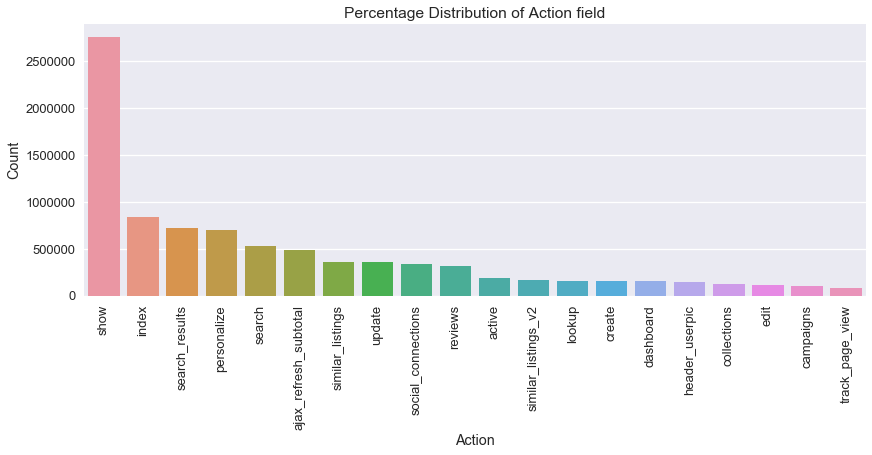

In [101]:
#Plotting the top 20 'action' field values :

plt.figure(figsize=(14,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('action', data = session_df,order = session_df['action'].value_counts().head(20).index)
plt.xlabel('Action')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Percentage Distribution of Action field')
plt.show()

Higher value of count means many users have performed that action many times. This is true because we have multiple session records for each customer. 

We see that <b>'show'</b> is the most used action followed by <i>'index'</i>. So, many customers have used the application many times mainly to perform 'show' action.

###### 2. Analysing the 'action_type'  field :

In [98]:
print('Total Unique Action Type : ')
action_type = session_df['action_type'].value_counts()
print(action_type)

Total Unique Action Type : 
view                3549375
data                2096655
click               1990058
na                  1122957
-unknown-           1028251
submit               620063
message_post          86925
partner_callback      19053
booking_request       18762
modify                 1138
booking_response          4
Name: action_type, dtype: int64


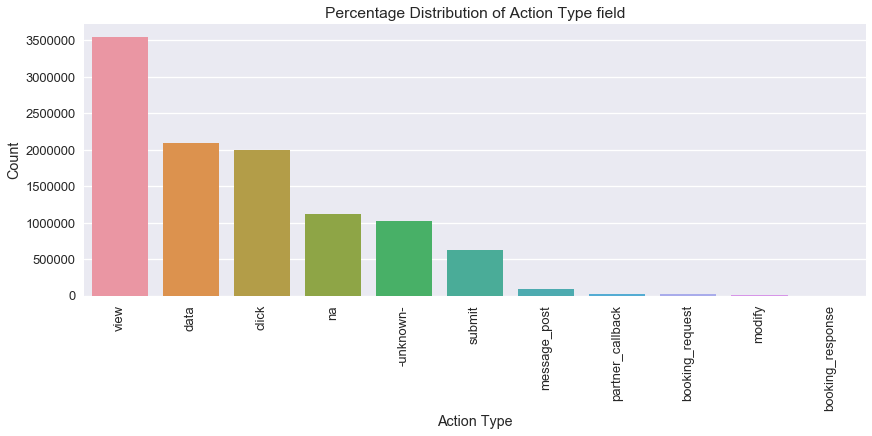

In [99]:
plt.figure(figsize=(14,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('action_type', data = session_df,order = session_df['action_type'].value_counts().index)
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Percentage Distribution of Action Type field')
plt.show()

Higher value of count means many users have performed that action_type many times. This is true because we have multiple session records for each customer. 

We see that <b>'view'</b> is the most used action_type followed by <i>'data'</i>. So, many customers have used the application many times mainly to view the different services offered.

Very less count for <b>'booking_request'</b> and <b>'booking_response'</b> means that very few users have actually made a request for booking or posted a response.

##### 3. Analysing the 'action_detail' field :

In [94]:
session_df['action_detail'].value_counts().head(30)

view_search_results            1771026
p3                             1371626
-unknown-                      1028222
wishlist_content_update         704782
user_profile                    654626
change_trip_characteristics     486414
similar_listings                363423
user_social_connections         335577
listing_reviews                 267991
update_listing                  267776
dashboard                       152515
user_wishlists                  152260
header_userpic                  141315
message_thread                  132199
edit_profile                    108531
message_post                     86925
contact_host                     80872
unavailable_dates                77475
confirm_email_link               58253
create_user                      54611
change_contact_host_dates        52426
user_profile_content_update      50353
user_reviews                     49424
p5                               48155
login                            38302
your_trips               

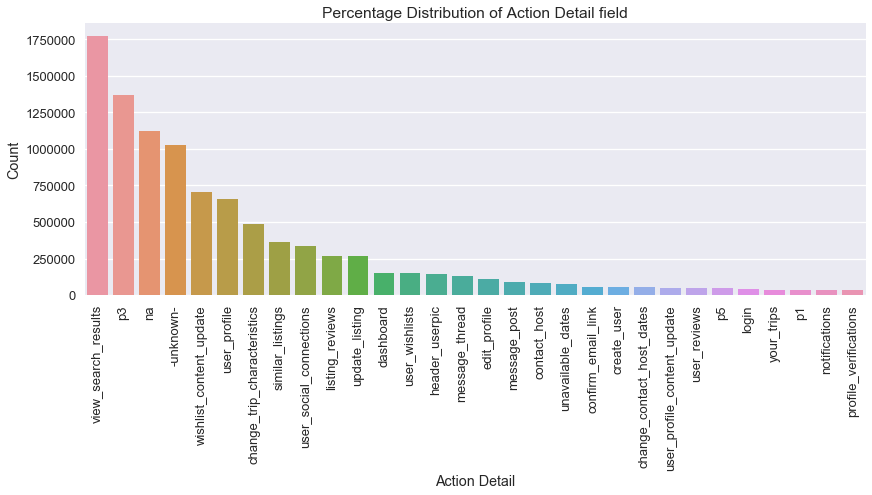

In [102]:
#Plotting the top 30 'action_detail' values :

plt.figure(figsize=(14,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('action_detail', data = session_df,order = session_df['action_detail'].value_counts().head(30).index)
plt.xlabel('Action Detail')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Percentage Distribution of Action Detail field')
plt.show()

Higher value of count means many users have performed that action_detail many times. This is true because we have multiple session records for each customer.

We see that 'view_search_results' is the most used action_type followed by 'p3'. So, many customers have used the application many times mainly to view the different services offered.

Very less count for 'profile_verifications' means that very few users have actually verified their accounts and hence are not serious about making a booking. This confirms that majority of the customers are only visiting the application mainly to explore the different services.

###### 4. Analysing the 'device_type' field :

In [94]:
print('Total Unique Device Type :')
device_type = session_df['device_type'].value_counts()
print(device_type)

Total Unique Device Type :
Mac Desktop                         3585886
Windows Desktop                     2648521
iPhone                              2096749
Android Phone                        835991
iPad Tablet                          681836
Android App Unknown Phone/Tablet     272820
-unknown-                            210059
Tablet                               139859
Linux Desktop                         27968
Chromebook                            22272
iPodtouch                              8186
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64


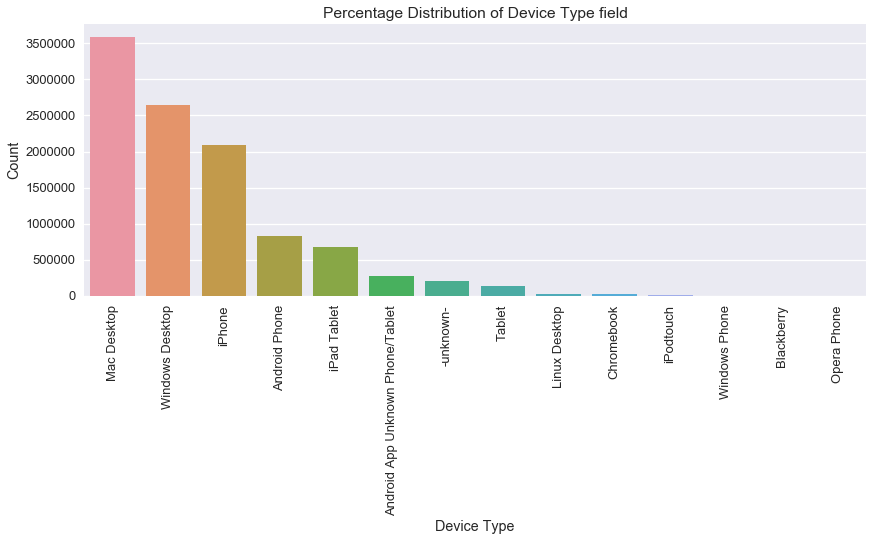

In [97]:
plt.figure(figsize=(14,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot('device_type', data = session_df,order = session_df['device_type'].value_counts().index)
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Percentage Distribution of Device Type field')
plt.show()

As seen in the EDA of the train data , majority of customers have used 'Mac Desktop' to access the application many times followed by 'Windows Desktop'.

In [49]:
session_df['action'].fillna('na', inplace=True)
session_df['action_type'].fillna('na', inplace=True)
session_df['action_detail'].fillna('na', inplace=True)

Filling the null values for 'action', 'action_type' and 'action_detail' with 'na'.

In [53]:
session_df.isnull().sum()

user_id               0
action                0
action_type           0
action_detail         0
device_type           0
secs_elapsed     135483
dtype: int64

We see now only 'secs_elapsed' has null values.

In [126]:
user_total_seconds = session_df.groupby('user_id')['secs_elapsed'].sum().reset_index()
user_total_seconds.columns = ['user_id', 'secs_elapsed']

In [127]:
user_total_seconds.head()

,user_id,secs_elapsed
0,00023iyk9l,867896.0
1,0010k6l0om,586543.0
2,001wyh0pz8,282965.0
3,0028jgx1x1,297010.0
4,002qnbzfs5,6487080.0


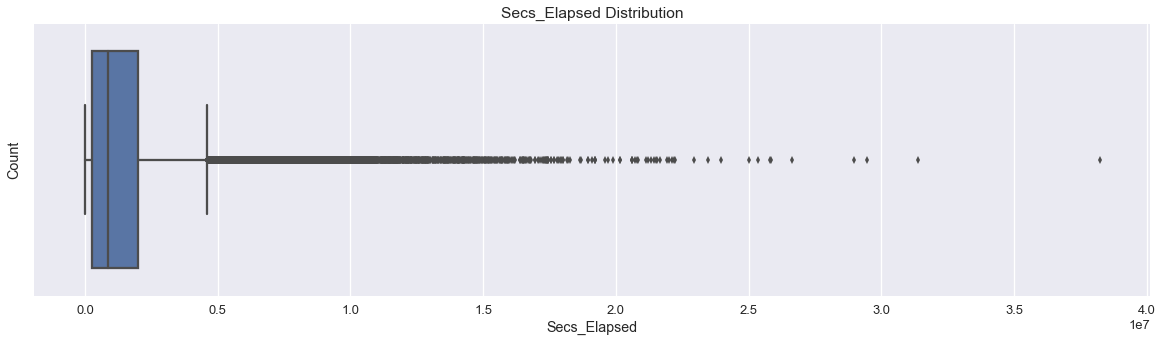

In [138]:
plt.figure(figsize=(20,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.boxplot(x=user_total_seconds['secs_elapsed']);
plt.xlabel('Secs_Elapsed');
plt.ylabel('Count');
plt.title('Secs_Elapsed Distribution');

In [139]:
user_total_seconds['secs_elapsed'].describe()

count    1.354830e+05
mean     1.489732e+06
std      1.892923e+06
min      0.000000e+00
25%      2.605980e+05
50%      8.502710e+05
75%      2.000422e+06
max      3.822136e+07
Name: secs_elapsed, dtype: float64

### FEATURE ENGINEERING :

###### Concatenating rows of session data for each user :

In [54]:
#https://stackoverflow.com/questions/34776651/concatenate-rows-of-pandas-dataframe-with-same-id

session_df_unq_rec1 = session_df.groupby('user_id', as_index=False).agg(lambda x: x.tolist())
print(session_df_unq_rec1.shape)
session_df_unq_rec1.head()

(135483, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,00023iyk9l,"[index, dashboard, header_userpic, dashboard, ...","[view, view, data, view, partner_callback, mes...","[view_search_results, dashboard, header_userpi...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De...","[20438.0, 787.0, 850.0, 934.0, nan, 129817.0, ..."
1,0010k6l0om,"[search_results, show, personalize, show, sear...","[click, view, data, na, click, click, na, data...","[view_search_results, p3, wishlist_content_upd...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De...","[1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,..."
2,001wyh0pz8,"[search, search, search, show, social_connecti...","[click, click, click, view, data, -unknown-, v...","[view_search_results, view_search_results, vie...","[Android App Unknown Phone/Tablet, Android App...","[622.0, 1813.0, 1507.0, 6327.0, 927.0, 142.0, ..."
3,0028jgx1x1,"[show, reviews, show, search, show, search, re...","[view, data, view, click, view, click, data, s...","[user_profile, listing_reviews, p3, view_searc...","[-unknown-, -unknown-, -unknown-, -unknown-, -...","[6162.0, 75.0, 86.0, 13710.0, 25217.0, 10989.0..."
4,002qnbzfs5,"[social_connections, payment_methods, create, ...","[data, -unknown-, -unknown-, view, data, data,...","[user_social_connections, -unknown-, -unknown-...","[iPhone, iPhone, iPhone, iPhone, iPhone, iPhon...","[17135.0, 711.0, 274.0, 179.0, 483.0, 1.0, 782..."


In [55]:
session_df_unq_rec1['secs_elapsed'].head()

0    [20438.0, 787.0, 850.0, 934.0, nan, 129817.0, ...
1    [1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,...
2    [622.0, 1813.0, 1507.0, 6327.0, 927.0, 142.0, ...
3    [6162.0, 75.0, 86.0, 13710.0, 25217.0, 10989.0...
4    [17135.0, 711.0, 274.0, 179.0, 483.0, 1.0, 782...
Name: secs_elapsed, dtype: object

<b>For the 'secs_elapsed' field, we are creating 3 features : </b>

1. Total seconds spent by each user across many sessions
2. Average seconds spent by each user
3. Count of number of sessions per user 

In [74]:
def total_sec(sec_list):
    
    """
    Function to calculate total time a particular user has spent in accessing the application.
        
    parameters: secs_elapsed 
    
    returns : total_secs_elapsed  
    
    """
    
    res = []
    
    #need to convert each element of the list to string so as to replace the 'nan' with '0' so that we dont get ValueError later.
    sec_list = [ str(i) for i in sec_list ] 
    sec_list = [ re.sub('nan','0',i) for i in sec_list] 
    
    #sec_list is a list of strings now. Iterating over the elements of the list.
    for i in sec_list:
        
        #Converting the string to float to take the sum later
        res.append(float(i)) 
    res = sum(res)
    return res

In [75]:
session_df_unq_rec1['Total_secs_elapsed'] = session_df_unq_rec1['secs_elapsed'].apply(total_sec)

In [77]:
from statistics import mean

def average_sec(sec_list):
    
    """
    Function to calculate average time a particular user has spent in accessing the application.
        
    parameters: secs_elapsed 
    
    returns : mean_secs_elapsed  
    
    """
    
    res = []
    
    #need to convert each element of the list to string so as to replace the 'nan' with '0' so that we dont get ValueError later.
    sec_list = [ str(i) for i in sec_list ] 
    sec_list = [ re.sub('nan','0',i) for i in sec_list] 
    
    #session_df is a list of strings now. Iterating over the elements of the list.
    for i in sec_list:
        
        #Converting the string to float to take the mean later
        res.append(float(i)) 
    res = mean(res)
    return res

In [78]:
session_df_unq_rec1['Mean_secs_elapsed'] = session_df_unq_rec1['secs_elapsed'].apply(average_sec)

In [80]:
def session_count(sec_list):
    
    """
    Function to calculate total sessions a particular user has used in accessing the application.
        
    parameters: secs_elapsed 
    
    returns : session_count  
    
    """
        
    return len(sec_list)

In [81]:
session_df_unq_rec1['session_count'] = session_df_unq_rec1['secs_elapsed'].apply(session_count)

For the action field, we are creating a <i>list of only the unique actions/devices</i> that the user has performed/used while accessing the application.

In [61]:
def unique_action(action):
    
    """
    Function to calculate unique actions per user.
        
    parameters: action/device_* 
    
    returns : unique_action/device_*  
    
    """
   
    action = [str(i) for i in action]
    
    action = [re.sub('nan','',i) for i in action]
    
    action = ','.join(set(action))
    
    return action

In [62]:
session_df_unq_rec1['unique_action'] = session_df_unq_rec1['action'].apply(unique_action)

In [65]:
session_df_unq_rec1['unique_action_type'] = session_df_unq_rec1['action_type'].apply(unique_action)

In [66]:
session_df_unq_rec1['unique_action_detail'] = session_df_unq_rec1['action_detail'].apply(unique_action)

In [67]:
session_df_unq_rec1['unique_device_type'] = session_df_unq_rec1['device_type'].apply(unique_action)

In [68]:
session_df_unq_rec1['unique_action'].head()

0    requested,personalize,header_userpic,pending,n...
1    personalize,header_userpic,show,callback,index...
2    create,search,active,social_connections,show,i...
3                    create,search,active,show,reviews
4    click,10,header_userpic,push_notification_call...
Name: unique_action, dtype: object

In [69]:
session_df_unq_rec1['unique_action_type'].head()

0    data,partner_callback,click,message_post,na,vi...
1        data,partner_callback,click,na,-unknown-,view
2                  data,click,na,-unknown-,view,submit
3                     data,click,-unknown-,view,submit
4    data,click,message_post,na,-unknown-,view,book...
Name: unique_action_type, dtype: object

In [70]:
session_df_unq_rec1['unique_action_detail'].head()

0    wishlist_content_update,message_post,header_us...
1    wishlist_content_update,header_userpic,na,-unk...
2    user_profile,user_social_connections,update_us...
3    p3,create_user,-unknown-,user_profile,listing_...
4    header_userpic,confirm_email_link,book_it,mess...
Name: unique_action_detail, dtype: object

In [71]:
session_df_unq_rec1['unique_device_type'].head()

0                  Mac Desktop,iPhone
1                         Mac Desktop
2    Android App Unknown Phone/Tablet
3             Android Phone,-unknown-
4                    iPhone,-unknown-
Name: unique_device_type, dtype: object

In [84]:
session_df_unq_rec1.shape

(135483, 13)

In [83]:
session_df_unq_rec1.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,00023iyk9l,"[index, dashboard, header_userpic, dashboard, ...","[view, view, data, view, partner_callback, mes...","[view_search_results, dashboard, header_userpi...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De...","[20438.0, 787.0, 850.0, 934.0, nan, 129817.0, ...","requested,personalize,header_userpic,pending,n...","data,partner_callback,click,message_post,na,vi...","wishlist_content_update,message_post,header_us...","Mac Desktop,iPhone",867896.0,21697.400000,40
1,0010k6l0om,"[search_results, show, personalize, show, sear...","[click, view, data, na, click, click, na, data...","[view_search_results, p3, wishlist_content_upd...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De...","[1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,...","personalize,header_userpic,show,callback,index...","data,partner_callback,click,na,-unknown-,view","wishlist_content_update,header_userpic,na,-unk...",Mac Desktop,586543.0,9310.206349,63
2,001wyh0pz8,"[search, search, search, show, social_connecti...","[click, click, click, view, data, -unknown-, v...","[view_search_results, view_search_results, vie...","[Android App Unknown Phone/Tablet, Android App...","[622.0, 1813.0, 1507.0, 6327.0, 927.0, 142.0, ...","create,search,active,social_connections,show,i...","data,click,na,-unknown-,view,submit","user_profile,user_social_connections,update_us...",Android App Unknown Phone/Tablet,282965.0,3144.055556,90


In [85]:
train_df.head(2)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,account_created_year
0,gxn3p5htnn,6/28/2010,2.009030e+13,-unknown-,34,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,0,6,2010
1,820tgsjxq7,5/25/2011,2.009050e+13,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2,5,2011


##### Merging the common users present in train and session file :

In [164]:
train_session_df = train_df.merge(session_df_unq_rec1, left_on = 'id', right_on = 'user_id', how = 'inner')
train_session_df.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,action_detail,device_type,secs_elapsed,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,d1mm9tcy42,1/1/2014,2.014010e+13,MALE,62,basic,0,en,sem-non-brand,google,...,"['na', 'view_search_results', 'na', 'view_sear...","['Windows Desktop', 'Windows Desktop', 'Window...","[319.0, 67753.0, 301.0, 22141.0, 435.0, 7703.0...","ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",3427529.0,26988.417323,127
1,yo8nz8bqcq,1/1/2014,2.014010e+13,-unknown-,34,basic,0,en,direct,direct,...,"['dashboard', 'create_user', 'confirm_email_li...","['Mac Desktop', 'Mac Desktop', 'Mac Desktop', ...","[2739.0, nan, 115983.0, 20285.0, 3255.0, 47308...","create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,207842.0,23093.555556,9
2,4grx6yxeby,1/1/2014,2.014010e+13,-unknown-,34,basic,0,en,sem-brand,google,...,"['-unknown-', 'create_user', 'message_post', '...","['Windows Desktop', 'Windows Desktop', 'Window...","[65080.0, nan, 59801.0, 1000.0, 1624.0, 5134.0...","create,requested,personalize,header_userpic,co...","data,message_post,-unknown-,view,booking_reque...","wishlist_content_update,message_post,p5,create...","Windows Desktop,-unknown-",1135444.0,70965.250000,16


In [88]:
print('Train Shape : ', train_df.shape)
print('Session Shape : ', session_df_unq_rec1.shape)
print('Merged Dataset Shape : ', train_session_df.shape)
print('Merged Dataset Column : ', train_session_df.columns)

Train Shape :  (213451, 18)
Session Shape :  (135483, 13)
Merged Dataset Shape :  (73815, 31)
Merged Dataset Column :  Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'account_created_day', 'account_created_month', 'account_created_year',
       'user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed', 'unique_action', 'unique_action_type',
       'unique_action_detail', 'unique_device_type', 'Total_secs_elapsed',
       'Mean_secs_elapsed', 'session_count'],
      dtype='object')


Only 73815 users of train file have their session data recorded. We will be modelling using only these records.

After creation of the new features the merged dataset have a total of 31 features.

In [89]:
train_session_df = train_session_df.drop(['date_account_created','action', 'action_type', 'action_detail', 'device_type','secs_elapsed'], axis = 1)
train_session_df.head(3)

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,account_created_month,account_created_year,user_id,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,d1mm9tcy42,2.014010e+13,MALE,62,basic,0,en,sem-non-brand,google,omg,...,1,2014,d1mm9tcy42,"ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",3427529.0,26988.417323,127
1,yo8nz8bqcq,2.014010e+13,-unknown-,34,basic,0,en,direct,direct,untracked,...,1,2014,yo8nz8bqcq,"create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,207842.0,23093.555556,9
2,4grx6yxeby,2.014010e+13,-unknown-,34,basic,0,en,sem-brand,google,omg,...,1,2014,4grx6yxeby,"create,requested,personalize,header_userpic,co...","data,message_post,-unknown-,view,booking_reque...","wishlist_content_update,message_post,p5,create...","Windows Desktop,-unknown-",1135444.0,70965.250000,16


Dropping the 'date_account_created','action', 'action_type', 'action_detail', 'device_type','secs_elapsed' because we have already preprocessed these features and created the needed proccessed ones.

In [93]:
train_session_df = train_session_df.drop(['timestamp_first_active'], axis = 1)
train_session_df.head(3)

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,account_created_month,account_created_year,user_id,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,d1mm9tcy42,MALE,62,basic,0,en,sem-non-brand,google,omg,Web,...,1,2014,d1mm9tcy42,"ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",3427529.0,26988.417323,127
1,yo8nz8bqcq,-unknown-,34,basic,0,en,direct,direct,untracked,Web,...,1,2014,yo8nz8bqcq,"create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,207842.0,23093.555556,9
2,4grx6yxeby,-unknown-,34,basic,0,en,sem-brand,google,omg,Web,...,1,2014,4grx6yxeby,"create,requested,personalize,header_userpic,co...","data,message_post,-unknown-,view,booking_reque...","wishlist_content_update,message_post,p5,create...","Windows Desktop,-unknown-",1135444.0,70965.250000,16


We will not be using the timestamp field in modelling so dropping it here.

In [107]:
train_session_df = train_session_df.drop(['user_id'], axis = 1)
train_session_df.head(3)

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,account_created_day,account_created_month,account_created_year,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,d1mm9tcy42,MALE,62,basic,0,en,sem-non-brand,google,omg,Web,...,2,1,2014,"ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",3427529.0,26988.417323,127
1,yo8nz8bqcq,-unknown-,34,basic,0,en,direct,direct,untracked,Web,...,2,1,2014,"create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,207842.0,23093.555556,9
2,4grx6yxeby,-unknown-,34,basic,0,en,sem-brand,google,omg,Web,...,2,1,2014,"create,requested,personalize,header_userpic,co...","data,message_post,-unknown-,view,booking_reque...","wishlist_content_update,message_post,p5,create...","Windows Desktop,-unknown-",1135444.0,70965.250000,16


The 'user_id' and 'id' columns present the same user so dropping user_id to reduce the redunduncy.

Till now we have a total of 23 features.

In [111]:
train_session_df.isnull().sum()

id                           0
gender                       0
age                          0
signup_method                0
signup_flow                  0
language                     0
affiliate_channel            0
affiliate_provider           0
first_affiliate_tracked    302
signup_app                   0
first_device_type            0
first_browser                0
country_destination          0
account_created_day          0
account_created_month        0
account_created_year         0
unique_action                0
unique_action_type           0
unique_action_detail         0
unique_device_type           0
Total_secs_elapsed           0
Mean_secs_elapsed            0
session_count                0
dtype: int64

In the merged dataset, 'first_affiliate_tracked' field has null values. Replacing the null values with the most used category i.e. 'untracked'.

In [112]:
train_session_df['first_affiliate_tracked'].describe()

count         73513
unique            7
top       untracked
freq          39049
Name: first_affiliate_tracked, dtype: object

In [113]:
train_session_df['first_affiliate_tracked'].fillna('untracked',inplace = True)

In [114]:
train_session_df.isnull().sum()

id                         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
account_created_day        0
account_created_month      0
account_created_year       0
unique_action              0
unique_action_type         0
unique_action_detail       0
unique_device_type         0
Total_secs_elapsed         0
Mean_secs_elapsed          0
session_count              0
dtype: int64

###### Creating the X and Y :

In [168]:
train_session_target = train_session_df['country_destination']

In [120]:
train_session_df = train_session_df.drop(['country_destination'], axis = 1)
train_session_df.shape

(73815, 22)

In [121]:
print('Class Label (Y) Shape : ', train_session_target.shape)
print('Merged Train Data Shape : ' , train_session_df.shape)

Class Label (Y) Shape :  (73815,)
Merged Train Data Shape :  (73815, 22)


After separating the 'country_destination' field as target variable, we now have a total of 22 features.

In [ ]:
train_session_df_backup = train_session_df

###### Creating the dummies for the different categorical features :

In [126]:
cat_list = ['gender', 'signup_method', 'language', 'affiliate_channel','affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

for i in cat_list:
    
    #creating the dummies for each category
    cat_train = pd.get_dummies(train_session_df[i], prefix=i) 
    
    #dropping the original feature after creating the dummies for it
    train_session_df.drop([i], axis=1, inplace = True)
    
    #Concatening the new dummy feature with the existing train_session_df dataset
    train_session_df = pd.concat((train_session_df, cat_train), axis=1)    

In [127]:
train_session_df.columns

Index(['id', 'age', 'signup_flow', 'account_created_day',
       'account_created_month', 'account_created_year', 'unique_action',
       'unique_action_type', 'unique_action_detail', 'unique_device_type',
       ...
       'first_browser_RockMelt', 'first_browser_Safari',
       'first_browser_SeaMonkey', 'first_browser_Silk',
       'first_browser_SiteKiosk', 'first_browser_Sogou Explorer',
       'first_browser_TenFourFox', 'first_browser_TheWorld Browser',
       'first_browser_Yandex.Browser', 'first_browser_wOSBrowser'],
      dtype='object', length=124)

In [129]:
train_session_df.shape

(73815, 124)

After creating the dummies for the categorical features we now have a total of 124 features.

###### Handling the 'unique_device_type' field differently because it is a comma separated list of categories :

In [132]:
#https://stackoverflow.com/questions/57469676/python-one-hot-encoding-for-comma-separated-values

cat_train = train_session_df['unique_device_type'].str.get_dummies(sep=",")
cat_train.columns

Index(['-unknown-', 'Android App Unknown Phone/Tablet', 'Android Phone',
       'Blackberry', 'Chromebook', 'Linux Desktop', 'Mac Desktop',
       'Opera Phone', 'Tablet', 'Windows Desktop', 'Windows Phone',
       'iPad Tablet', 'iPhone', 'iPodtouch'],
      dtype='object')

In [133]:
train_session_df = pd.concat((train_session_df, cat_train), axis=1)
train_session_df.shape

(73815, 138)

After the dummies of 'unique_device_type' is created , we now have a total of 138 features.

In [134]:
train_session_df.head(2)

,id,age,signup_flow,account_created_day,account_created_month,account_created_year,unique_action,unique_action_type,unique_action_detail,unique_device_type,...,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
0,d1mm9tcy42,62,0,2,1,2014,"ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",...,0,0,0,0,0,1,0,0,0,0
1,yo8nz8bqcq,34,0,2,1,2014,"create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,...,0,0,1,0,0,0,0,0,0,0


In [232]:
train_session_df_final = train_session_df.drop(['id'],axis = 1)
train_session_df_final.head(2)

,age,signup_flow,account_created_day,account_created_month,account_created_year,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,...,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
0,62,0,2,1,2014,"ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",3427529.0,...,0,0,0,0,0,1,0,0,0,0
1,34,0,2,1,2014,"create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,207842.0,...,0,0,1,0,0,0,0,0,0,0


Dropping the 'id' column.

Final count of features is 137.

##### Splitting the Train data into Train and Test(CV) for modelling :

In [31]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(train_session_df_final, train_session_target, test_size = 0.2, random_state = 817)

In [32]:
print('X_Train : ',X_Train.shape)
print('Y_Train : ',Y_Train.shape)
print('X_Test : ',X_Test.shape)
print('Y_Test : ',Y_Test.shape)

X_Train :  (59052, 137)
Y_Train :  (59052,)
X_Test :  (14763, 137)
Y_Test :  (14763,)


In [33]:
X_Train.head(2)

,age,signup_flow,account_created_day,account_created_month,account_created_year,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,...,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
64594,24,23,4,6,2014,"create,pay,search,payment_methods,active,unava...","data,click,message_post,na,-unknown-,view,book...","user_listings,user_profile,user_social_connect...",Android Phone,4127687.0,...,0,0,0,0,0,0,0,0,0,0
30010,62,0,5,3,2014,"personalize,header_userpic,show,index,authenti...","data,na,view,click","wishlist_content_update,login_page,header_user...",Windows Desktop,168104.0,...,0,0,0,0,0,1,0,0,0,0


#### TFIDF Vectorization for the text fields :

###### Creation of  unigram and bigram features for 'unique_action' field  :

In [12]:
tfidf_vect_action = TfidfVectorizer(min_df=10,max_features=5000,ngram_range = (1,2))

tfidf_vect_action.fit(X_Train['unique_action'].values)

train_session_action_tfidf = tfidf_vect_action.transform(X_Train['unique_action'].values)

In [13]:
test_session_action_tfidf = tfidf_vect_action.transform(X_Test['unique_action'].values)

In [14]:
train_session_action_tfidf.shape

(59052, 3066)

In [15]:
test_session_action_tfidf.shape

(14763, 3066)

In [16]:
print('Top 30 Feature Names for Action : ',tfidf_vect_action.get_feature_names()[:30])

Top 30 Feature Names for Action :  ['10', '10 active', '10 click', '10 header_userpic', '10 na', '10 search', '10 unavailabilities', '11', '11 active', '11 na', '11 pending', '12', '12 active', '12 ajax_check_dates', '12 at_checkpoint', '12 authenticate', '12 calendar_tab_inner2', '12 cancellation_policies', '12 complete_status', '12 na', '12 payment_instruments', '12 pending', '12 phone_verification_success', '12 reviews_new', '15', '15 phone_number_widget', '15 update', 'about_us', 'about_us na', 'about_us show']


##### Creation of bigram and trigram features for 'unique_action_type' field :

In [17]:
tfidf_vect_action_type = TfidfVectorizer(min_df=10,max_features=5000,ngram_range = (2,3))

tfidf_vect_action_type.fit(X_Train['unique_action_type'].values)

train_session_action_type_tfidf = tfidf_vect_action_type.transform(X_Train['unique_action_type'].values)

In [18]:
test_session_action_type_tfidf = tfidf_vect_action_type.transform(X_Test['unique_action_type'].values)

In [19]:
train_session_action_type_tfidf.shape

(59052, 148)

In [20]:
test_session_action_type_tfidf.shape

(14763, 148)

In [21]:
print('Top 30 Feature Names for Action Type : ',tfidf_vect_action_type.get_feature_names()[:30])

Top 30 Feature Names for Action Type :  ['booking_request click', 'booking_request click unknown', 'booking_request message_post', 'booking_request submit', 'booking_request submit unknown', 'booking_request unknown', 'booking_request view', 'booking_request view message_post', 'click message_post', 'click message_post na', 'click message_post unknown', 'click message_post view', 'click na', 'click na unknown', 'click na view', 'click partner_callback', 'click partner_callback message_post', 'click partner_callback na', 'click partner_callback unknown', 'click unknown', 'click unknown message_post', 'click unknown na', 'click unknown view', 'click view', 'click view booking_request', 'click view message_post', 'click view na', 'data click', 'data click message_post', 'data click na']


###### Creation of unigram and bigram features for 'unique_action_detail' field :

In [22]:
tfidf_vect_action_detail = TfidfVectorizer(min_df=10,max_features=5000,ngram_range = (1,2))

tfidf_vect_action_detail.fit(X_Train['unique_action_detail'].values)

train_session_action_detail_tfidf = tfidf_vect_action_detail.transform(X_Train['unique_action_detail'].values)

In [23]:
test_session_action_detail_tfidf = tfidf_vect_action_detail.transform(X_Test['unique_action_detail'].values)

In [24]:
train_session_action_detail_tfidf.shape

(59052, 1819)

In [25]:
test_session_action_detail_tfidf.shape

(14763, 1819)

In [26]:
print('Top 30 Feature Names for Action Detail : ',tfidf_vect_action_detail.get_feature_names()[:30])

Top 30 Feature Names for Action Detail :  ['account_notification_settings', 'account_notification_settings account_privacy_settings', 'account_notification_settings apply_coupon', 'account_notification_settings confirm_email_link', 'account_notification_settings create_phone_numbers', 'account_notification_settings create_user', 'account_notification_settings header_userpic', 'account_notification_settings message_post', 'account_notification_settings message_thread', 'account_notification_settings na', 'account_notification_settings p1', 'account_notification_settings unknown', 'account_notification_settings update_listing', 'account_notification_settings user_profile', 'account_notification_settings your_trips', 'account_payout_preferences', 'account_payout_preferences oauth_response', 'account_payout_preferences wishlist_content_update', 'account_privacy_settings', 'account_privacy_settings manage_listing', 'account_privacy_settings message_thread', 'account_privacy_settings na', 'a

In [34]:
X_Train['unique_action'].head(2)

64594    create,pay,search,payment_methods,active,unava...
30010    personalize,header_userpic,show,index,authenti...
Name: unique_action, dtype: object

In [52]:
X_Test.head(2)

,age,signup_flow,account_created_day,account_created_month,account_created_year,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,...,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
56504,29,0,2,5,2014,"create,this_hosting_reviews,personalize,header...","data,click,na,view,submit","wishlist_content_update,update_listing,header_...",Mac Desktop,2241894.0,...,0,0,1,0,0,0,0,0,0,0
14314,27,0,3,2,2014,"ajax_lwlb_contact,create,requested,ask_questio...","data,click,message_post,na,-unknown-,view,book...","change_contact_host_dates,wishlist_content_upd...",Mac Desktop,782837.0,...,0,0,1,0,0,0,0,0,0,0


After creation of vectors for the different text field, we are dropping the original non-vectorised features from the train and test dataset.

In [66]:
X_Train_vec = X_Train.drop(['unique_action','unique_action_type','unique_action_detail','unique_device_type'],axis=1)
X_Train_vec.shape

(59052, 133)

In [67]:
final_column_list = [col for col in X_Train_vec.columns]
final_column_list

['age',
 'signup_flow',
 'account_created_day',
 'account_created_month',
 'account_created_year',
 'Total_secs_elapsed',
 'Mean_secs_elapsed',
 'session_count',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'gender_OTHER',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_method_google',
 'language_ca',
 'language_cs',
 'language_da',
 'language_de',
 'language_el',
 'language_en',
 'language_es',
 'language_fi',
 'language_fr',
 'language_hu',
 'language_id',
 'language_is',
 'language_it',
 'language_ja',
 'language_ko',
 'language_nl',
 'language_no',
 'language_pl',
 'language_pt',
 'language_ru',
 'language_sv',
 'language_th',
 'language_tr',
 'language_zh',
 'affiliate_channel_api',
 'affiliate_channel_content',
 'affiliate_channel_direct',
 'affiliate_channel_other',
 'affiliate_channel_remarketing',
 'affiliate_channel_sem-brand',
 'affiliate_channel_sem-non-brand',
 'affiliate_channel_seo',
 'affiliate_provider_baidu',
 'affiliate_provider_bing',
 'affili

In [68]:
len(final_column_list)

133

Saving the names of features in a list for future use.

In [53]:
X_Test_vec = X_Test.drop(['unique_action','unique_action_type','unique_action_detail','unique_device_type'],axis=1)
X_Test_vec.shape

(14763, 133)

###### Concatenating the vectorised feartures with the remaining original features :

In [72]:
X_Train_vec = sparse.hstack((X_Train_vec,train_session_action_tfidf,train_session_action_type_tfidf,train_session_action_detail_tfidf)).tocsr()
X_Train_vec.shape

(59052, 5166)

In [55]:
X_Test_vec = sparse.hstack((X_Test_vec,test_session_action_tfidf,test_session_action_type_tfidf,test_session_action_detail_tfidf)).tocsr()
X_Test_vec.shape

(14763, 5166)

Concatenating the vectorised feature names with the original list of feature names

In [69]:
final_column_list.extend(tfidf_vect_action.get_feature_names())
final_column_list.extend(tfidf_vect_action_type.get_feature_names())
final_column_list.extend(tfidf_vect_action_detail.get_feature_names())

len(final_column_list)

5166

In [84]:
final_column_list

['age',
 'signup_flow',
 'account_created_day',
 'account_created_month',
 'account_created_year',
 'Total_secs_elapsed',
 'Mean_secs_elapsed',
 'session_count',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'gender_OTHER',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_method_google',
 'language_ca',
 'language_cs',
 'language_da',
 'language_de',
 'language_el',
 'language_en',
 'language_es',
 'language_fi',
 'language_fr',
 'language_hu',
 'language_id',
 'language_is',
 'language_it',
 'language_ja',
 'language_ko',
 'language_nl',
 'language_no',
 'language_pl',
 'language_pt',
 'language_ru',
 'language_sv',
 'language_th',
 'language_tr',
 'language_zh',
 'affiliate_channel_api',
 'affiliate_channel_content',
 'affiliate_channel_direct',
 'affiliate_channel_other',
 'affiliate_channel_remarketing',
 'affiliate_channel_sem-brand',
 'affiliate_channel_sem-non-brand',
 'affiliate_channel_seo',
 'affiliate_provider_baidu',
 'affiliate_provider_bing',
 'affili

Total number of features (Categorical Dummy Features + Text Vectorised Features ) is 5166.

###### Saving everything that we have created for future use :

Saving the final Train and Test(CV) Dataset :

In [74]:
#https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
from scipy import sparse

sparse.save_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\X_Train_vec.npz', X_Train_vec)
sparse.save_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\X_Test_vec.npz', X_Test_vec)

Saving the list of final feature names :

In [75]:
#https://stackoverflow.com/questions/27745500/how-to-save-a-list-to-a-file-and-read-it-as-a-list-type

import pickle

with open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\final_column_list.txt', 'wb') as fp:   #Pickling
    pickle.dump(final_column_list, fp)
fp.close()

Saving the vectorisers for different text fields :

In [76]:
#https://stackoverflow.com/questions/32764991/how-do-i-store-a-tfidfvectorizer-for-future-use-in-scikit-learn

pickle.dump(tfidf_vect_action, open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\tfidf_vect_action.pickle', 'wb'))
pickle.dump(tfidf_vect_action_type, open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\tfidf_vect_action_type.pickle', 'wb'))
pickle.dump(tfidf_vect_action_detail, open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\tfidf_vect_action_detail.pickle', 'wb'))

###### Loading the saved files to check if everything is saved properly :

In [77]:
X_Train_vec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\X_Train_vec.npz')
X_Test_vec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\X_Test_vec.npz')

with open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\final_column_list.txt', 'rb') as fp:   # Unpickling
    final_column_list = pickle.load(fp)
fp.close()

In [78]:
tfidf_vect_action = pickle.load(open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\tfidf_vect_action.pickle', 'rb'))
tfidf_vect_action_type = pickle.load(open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\tfidf_vect_action_type.pickle', 'rb'))
tfidf_vect_action_detail = pickle.load(open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\tfidf_vect_action_detail.pickle', 'rb'))

In [82]:
print("Final Preprocessed and Vectorized Dataset :")
print('Train Dataset : ',X_Train_vec.shape)
print('Test Dataset : ',X_Test_vec.shape)
print("="*100)
print('Total Action Features :',len(tfidf_vect_action.get_feature_names()))
print('Total Action Type Features :', len(tfidf_vect_action_type.get_feature_names()))
print('Total Action Detail Features :', len(tfidf_vect_action_detail.get_feature_names()))
print("="*100)
print('Total Number of Columns : ',len(final_column_list))
print('Total Target (Train + Test) Variable Count : ',train_session_target.shape)
#print(len(lst_ohe_train))
print("="*100)

Final Preprocessed and Vectorized Dataset :
Train Dataset :  (59052, 5166)
Test Dataset :  (14763, 5166)
Total Action Features : 3066
Total Action Type Features : 148
Total Action Detail Features : 1819
Total Number of Columns :  5166
Total Target (Train + Test) Variable Count :  (73815,)


###### Saving and loading the files in different stages of this notebook :

In [8]:
train_session_df.head(2)

,id,age,signup_flow,account_created_day,account_created_month,account_created_year,unique_action,unique_action_type,unique_action_detail,unique_device_type,...,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
0,d1mm9tcy42,62,0,2,1,2014,"ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",...,0,0,0,0,0,1,0,0,0,0
1,yo8nz8bqcq,34,0,2,1,2014,"create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,...,0,0,1,0,0,0,0,0,0,0


In [7]:
train_session_df_final.head(2)

,age,signup_flow,account_created_day,account_created_month,account_created_year,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,...,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
0,62,0,2,1,2014,"ajax_refresh_subtotal,hosting_social_proof,ask...","data,click,message_post,na,-unknown-,view,submit","wishlist_content_update,header_userpic,message...","Windows Desktop,-unknown-",3427529.0,...,0,0,0,0,0,1,0,0,0,0
1,34,0,2,1,2014,"create,show_personalize,personalize,header_use...","data,click,na,view,submit","wishlist_content_update,user_profile,confirm_e...",Mac Desktop,207842.0,...,0,0,1,0,0,0,0,0,0,0


In [261]:
#train final without id
train_session_df_final.to_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\train_session_df_final.pickle')

In [6]:
train_session_df_final = pd.read_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\train_session_df_final.pickle')

In [176]:
train_session_target.to_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\train_session_Y.pickle')

In [5]:
train_session_target = pd.read_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\train_session_Y.pickle')

In [139]:
train_session_df.to_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\train_session_df.pickle')

In [4]:
train_session_df = pd.read_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\train_session_df.pickle')

In [135]:
session_df_unq_rec1.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\sessions.csv\sessions_preprocessed1.csv', index=False)

In [136]:
session_df_unq_rec1 = pd.read_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\sessions.csv\sessions_preprocessed1.csv')
print('Shape of the Train Data : ',session_df_unq_rec1.shape)
print('Columns of Train Data : ', session_df_unq_rec1.columns)
session_df_unq_rec1.head()

Shape of the Train Data :  (135483, 13)
Columns of Train Data :  Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed', 'unique_action', 'unique_action_type',
       'unique_action_detail', 'unique_device_type', 'Total_secs_elapsed',
       'Mean_secs_elapsed', 'session_count'],
      dtype='object')


,user_id,action,action_type,action_detail,device_type,secs_elapsed,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,00023iyk9l,"['index', 'dashboard', 'header_userpic', 'dash...","['view', 'view', 'data', 'view', 'partner_call...","['view_search_results', 'dashboard', 'header_u...","['Mac Desktop', 'Mac Desktop', 'Mac Desktop', ...","[20438.0, 787.0, 850.0, 934.0, nan, 129817.0, ...","requested,personalize,header_userpic,pending,n...","data,partner_callback,click,message_post,na,vi...","wishlist_content_update,message_post,header_us...","Mac Desktop,iPhone",867896.0,21697.400000,40
1,0010k6l0om,"['search_results', 'show', 'personalize', 'sho...","['click', 'view', 'data', 'na', 'click', 'clic...","['view_search_results', 'p3', 'wishlist_conten...","['Mac Desktop', 'Mac Desktop', 'Mac Desktop', ...","[1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,...","personalize,header_userpic,show,callback,index...","data,partner_callback,click,na,-unknown-,view","wishlist_content_update,header_userpic,na,-unk...",Mac Desktop,586543.0,9310.206349,63
2,001wyh0pz8,"['search', 'search', 'search', 'show', 'social...","['click', 'click', 'click', 'view', 'data', '-...","['view_search_results', 'view_search_results',...","['Android App Unknown Phone/Tablet', 'Android ...","[622.0, 1813.0, 1507.0, 6327.0, 927.0, 142.0, ...","create,search,active,social_connections,show,i...","data,click,na,-unknown-,view,submit","user_profile,user_social_connections,update_us...",Android App Unknown Phone/Tablet,282965.0,3144.055556,90
3,0028jgx1x1,"['show', 'reviews', 'show', 'search', 'show', ...","['view', 'data', 'view', 'click', 'view', 'cli...","['user_profile', 'listing_reviews', 'p3', 'vie...","['-unknown-', '-unknown-', '-unknown-', '-unkn...","[6162.0, 75.0, 86.0, 13710.0, 25217.0, 10989.0...","create,search,active,show,reviews","data,click,-unknown-,view,submit","p3,create_user,-unknown-,user_profile,listing_...","Android Phone,-unknown-",297010.0,9580.967742,31
4,002qnbzfs5,"['social_connections', 'payment_methods', 'cre...","['data', '-unknown-', '-unknown-', 'view', 'da...","['user_social_connections', '-unknown-', '-unk...","['iPhone', 'iPhone', 'iPhone', 'iPhone', 'iPho...","[17135.0, 711.0, 274.0, 179.0, 483.0, 1.0, 782...","click,10,header_userpic,push_notification_call...","data,click,message_post,na,-unknown-,view,book...","header_userpic,confirm_email_link,book_it,mess...","iPhone,-unknown-",6487080.0,8221.901141,789


In [3]:
session_df_unq_rec1 = pd.read_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\sessions.csv\sessions_preprocessed1.csv')
print('Shape of the Train Data : ',session_df_unq_rec1.shape)
print('Columns of Train Data : ', session_df_unq_rec1.columns)
session_df_unq_rec1.head(2)

Shape of the Train Data :  (135483, 13)
Columns of Train Data :  Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed', 'unique_action', 'unique_action_type',
       'unique_action_detail', 'unique_device_type', 'Total_secs_elapsed',
       'Mean_secs_elapsed', 'session_count'],
      dtype='object')


,user_id,action,action_type,action_detail,device_type,secs_elapsed,unique_action,unique_action_type,unique_action_detail,unique_device_type,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,00023iyk9l,"['index', 'dashboard', 'header_userpic', 'dash...","['view', 'view', 'data', 'view', 'partner_call...","['view_search_results', 'dashboard', 'header_u...","['Mac Desktop', 'Mac Desktop', 'Mac Desktop', ...","[20438.0, 787.0, 850.0, 934.0, nan, 129817.0, ...","requested,personalize,header_userpic,pending,n...","data,partner_callback,click,message_post,na,vi...","wishlist_content_update,message_post,header_us...","Mac Desktop,iPhone",867896.0,21697.400000,40
1,0010k6l0om,"['search_results', 'show', 'personalize', 'sho...","['click', 'view', 'data', 'na', 'click', 'clic...","['view_search_results', 'p3', 'wishlist_conten...","['Mac Desktop', 'Mac Desktop', 'Mac Desktop', ...","[1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,...","personalize,header_userpic,show,callback,index...","data,partner_callback,click,na,-unknown-,view","wishlist_content_update,header_userpic,na,-unk...",Mac Desktop,586543.0,9310.206349,63


In [4]:
session_df_unq_rec1 = pd.read_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\sessions.csv\sessions_preprocessed1.csv')
print('Shape of the Train Data : ',session_df_unq_rec1.shape)
print('Columns of Train Data : ', session_df_unq_rec1.columns)
session_df_unq_rec1.head()

Shape of the Train Data :  (135483, 9)
Columns of Train Data :  Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed', 'Total_secs_elapsed', 'Mean_secs_elapsed',
       'session_count'],
      dtype='object')


,user_id,action,action_type,action_detail,device_type,secs_elapsed,Total_secs_elapsed,Mean_secs_elapsed,session_count
0,00023iyk9l,"['index', 'dashboard', 'header_userpic', 'dash...","['view', 'view', 'data', 'view', 'partner_call...","['view_search_results', 'dashboard', 'header_u...","['Mac Desktop', 'Mac Desktop', 'Mac Desktop', ...","[20438.0, 787.0, 850.0, 934.0, nan, 129817.0, ...",867896.0,21697.400000,40
1,0010k6l0om,"['search_results', 'show', 'personalize', 'sho...","['click', 'view', 'data', 'na', 'click', 'clic...","['view_search_results', 'p3', 'wishlist_conten...","['Mac Desktop', 'Mac Desktop', 'Mac Desktop', ...","[1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,...",586543.0,9310.206349,63
2,001wyh0pz8,"['search', 'search', 'search', 'show', 'social...","['click', 'click', 'click', 'view', 'data', '-...","['view_search_results', 'view_search_results',...","['Android App Unknown Phone/Tablet', 'Android ...","[622.0, 1813.0, 1507.0, 6327.0, 927.0, 142.0, ...",282965.0,3144.055556,90
3,0028jgx1x1,"['show', 'reviews', 'show', 'search', 'show', ...","['view', 'data', 'view', 'click', 'view', 'cli...","['user_profile', 'listing_reviews', 'p3', 'vie...","['-unknown-', '-unknown-', '-unknown-', '-unkn...","[6162.0, 75.0, 86.0, 13710.0, 25217.0, 10989.0...",297010.0,9580.967742,31
4,002qnbzfs5,"['social_connections', 'payment_methods', 'cre...","['data', '-unknown-', '-unknown-', 'view', 'da...","['user_social_connections', '-unknown-', '-unk...","['iPhone', 'iPhone', 'iPhone', 'iPhone', 'iPho...","[17135.0, 711.0, 274.0, 179.0, 483.0, 1.0, 782...",6487080.0,8221.901141,789
